# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- 18/0113097 Daniel Coimbra
- 18/0075462 Gabriel Freitas Balbino
- 17/0145514 Iuri de Souza Severo Alves
- 17/0013910 João Pedro José
- 16/0133394 Lucas Fellipe Carvalho Moreira
- 20/0025449 Natan Tavares Santana
- 19/0109963 João Victor Teixeira Batista
- 19/0094257 Paulo Henrique
- 17/0062686 Pedro Rodrigues

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here
print(jsons[0])

../analytics-raw-data/fga-eps-mds-2021.1-Pro-Especies-FishWiki-10-27-2021-18-11.json


In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"Pro-Especies-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
456,complexity,1,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
457,duplicated_lines_density,0.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
458,functions,1,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
459,ncloc,11,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
460,reliability_rating,1.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
461,security_rating,1.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
462,comment_lines_density,0.0,False,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
463,files,7,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
168,duplicated_lines_density,0.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
169,functions,19,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)
        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"Pro-Especies-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
706,src/index.ts,1,1,0.0,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
242,src/app.ts,0,0,0.0,0.0,NaN,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
243,src/middleware/auth.ts,3,5,0.0,0.0,38.9,31,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
244,src/config/database.ts,2,4,0.0,0.0,NaN,27,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
245,src/models/fishLog.ts,0,0,0.0,0.0,100.0,89,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
246,src/controllers/fishLogController.ts,7,26,0.0,0.0,91.5,189,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
247,src/routes/fishLogRoutes.ts,6,6,0.0,0.0,0.0,25,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
248,src/routes/router.ts,0,0,16.7,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
249,src/server.ts,1,2,0.0,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
314,src/app.ts,0,0,0.0,0.0,NaN,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-10-18-...,FishLog,10-18-2021-06-28


#### Create dataframe per repository

In [12]:
repo1_df = file_component_df[file_component_df['repository'] == 'UserInterface']
repo2_df = file_component_df[file_component_df['repository'] == 'User']
repo3_df = file_component_df[file_component_df['repository'] == 'FishWiki']
repo4_df = file_component_df[file_component_df['repository'] == 'FishLog']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [14]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [17]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [18]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [19]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [20]:
def create_metrics_df(df):
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    for version in version_vec:
        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [21]:
repo1_metrics = create_metrics_df(repo1_df)
repo2_metrics = create_metrics_df(repo2_df)
repo3_metrics = create_metrics_df(repo3_df)
repo4_metrics = create_metrics_df(repo4_df)

### Data visualization

- You must do this for each of your repositories

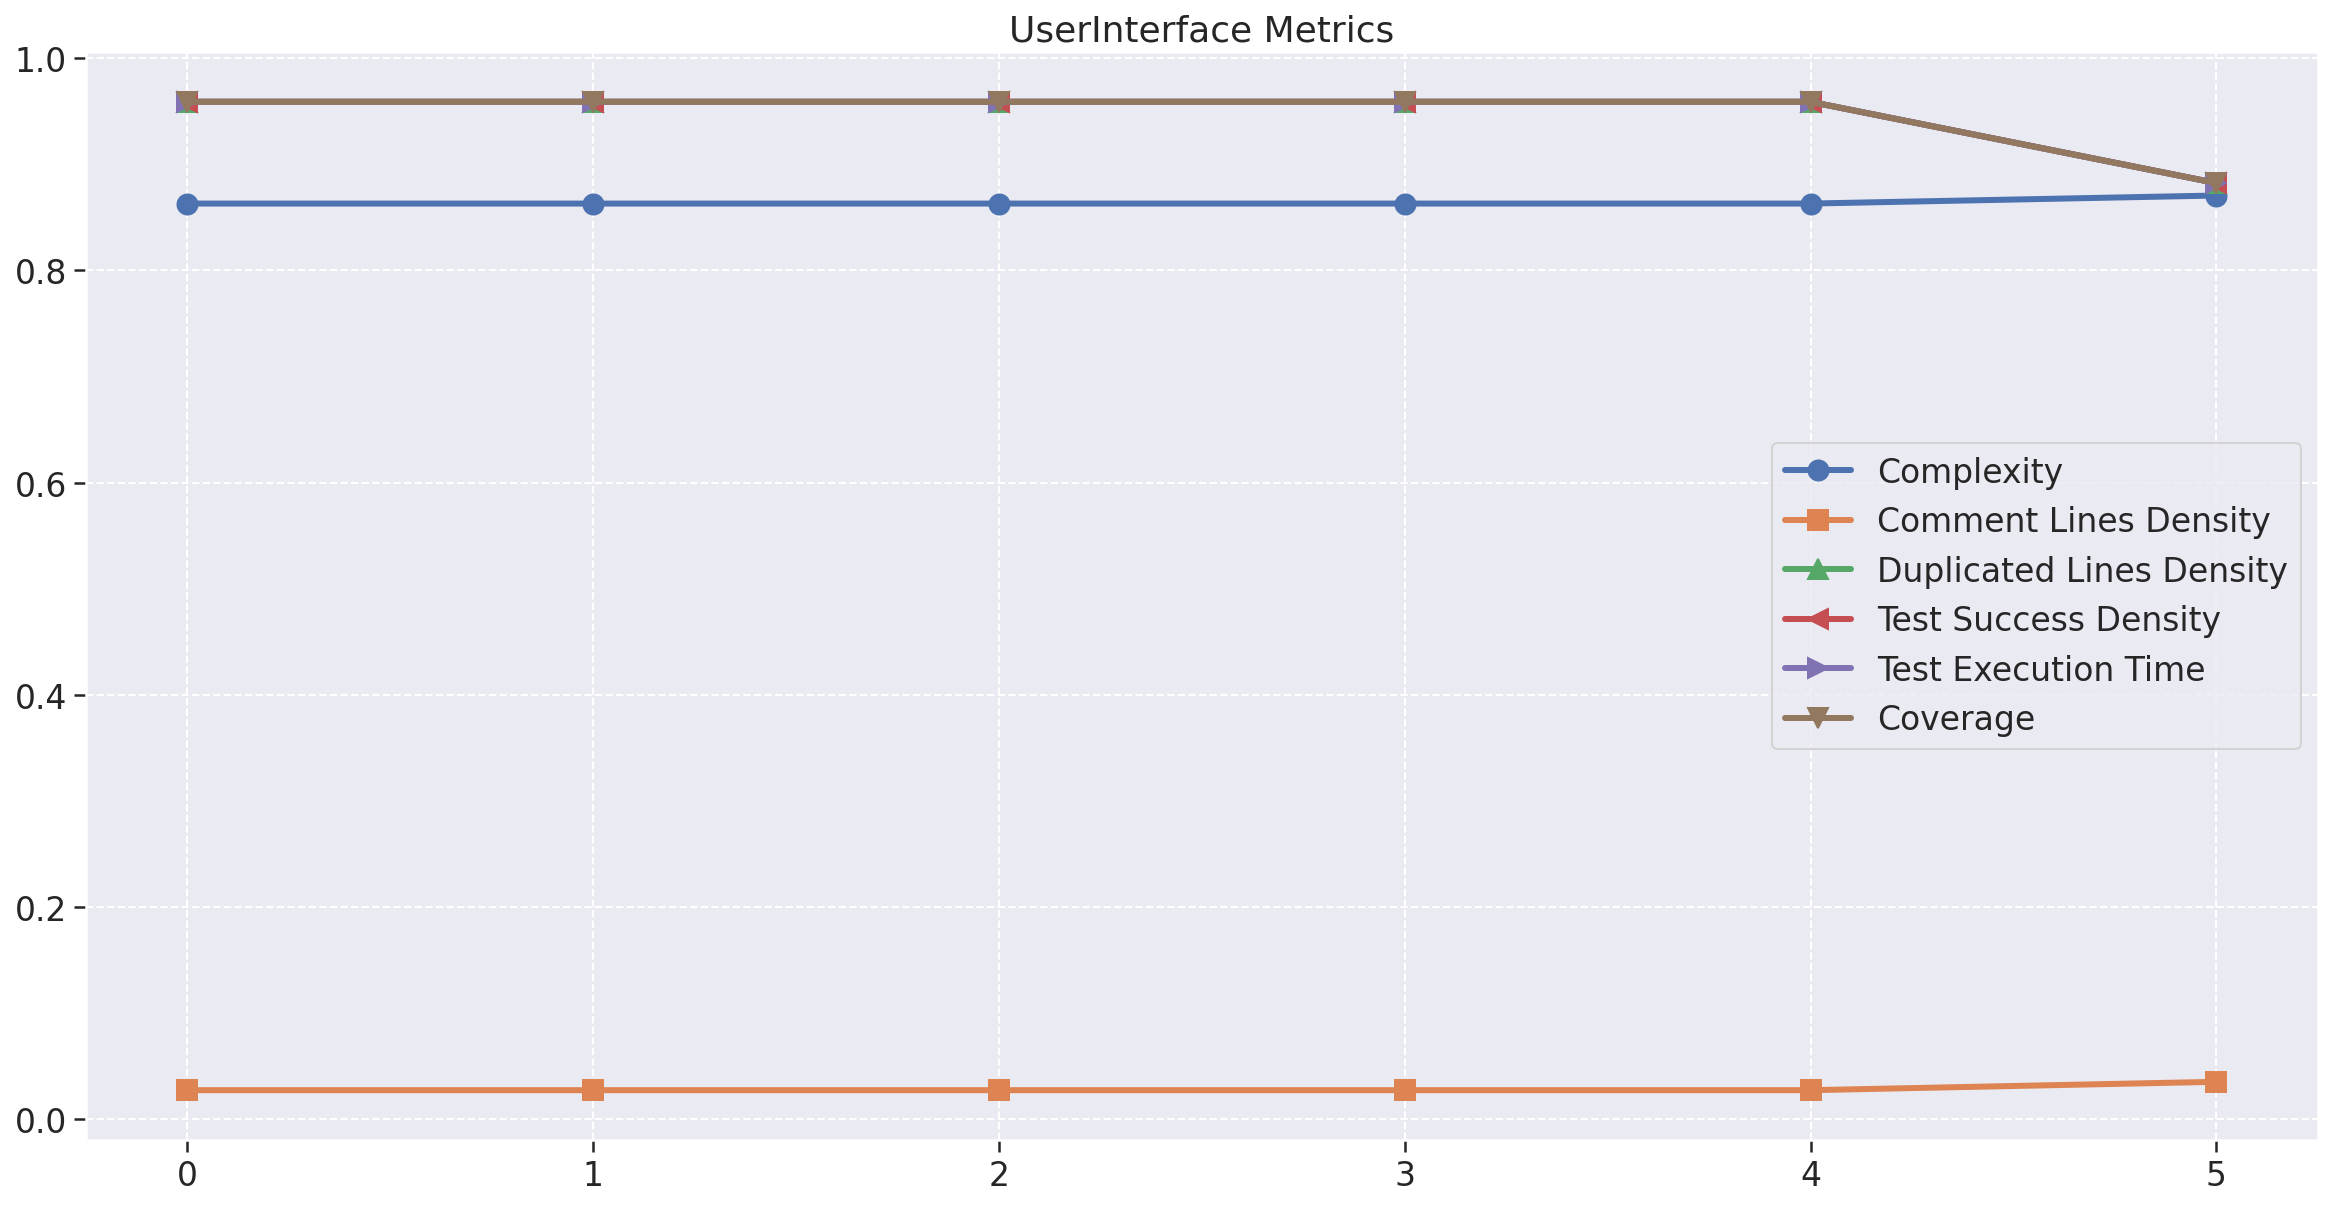

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.title('UserInterface Metrics')
plt.plot(repo1_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo1_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo1_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo1_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo1_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo1_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

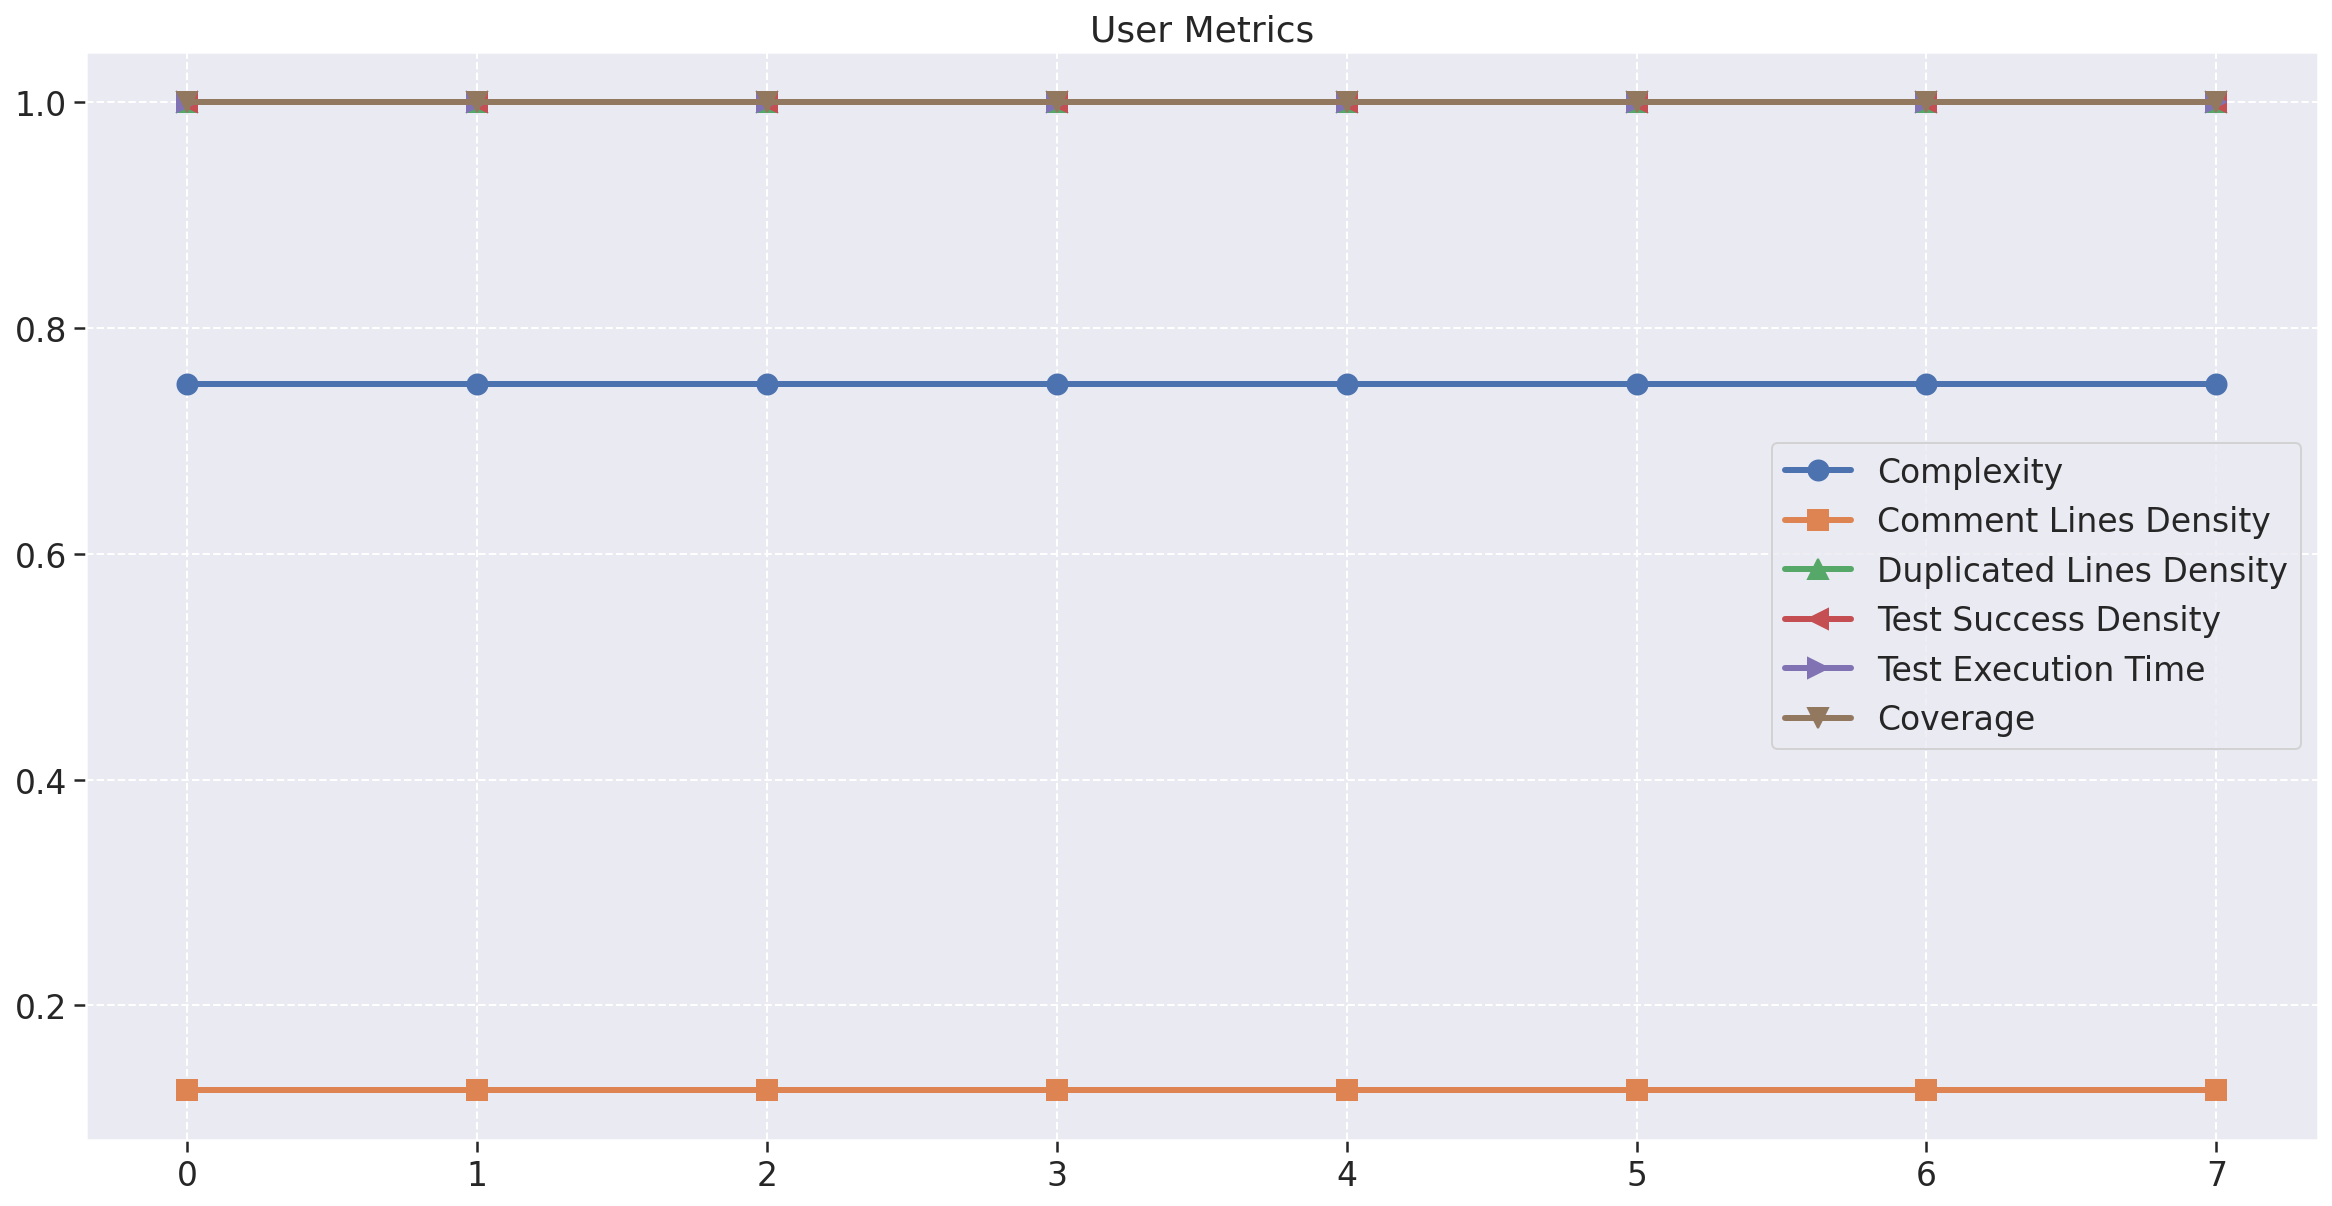

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.title('User Metrics')
plt.plot(repo2_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo2_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo2_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo2_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo2_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo2_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

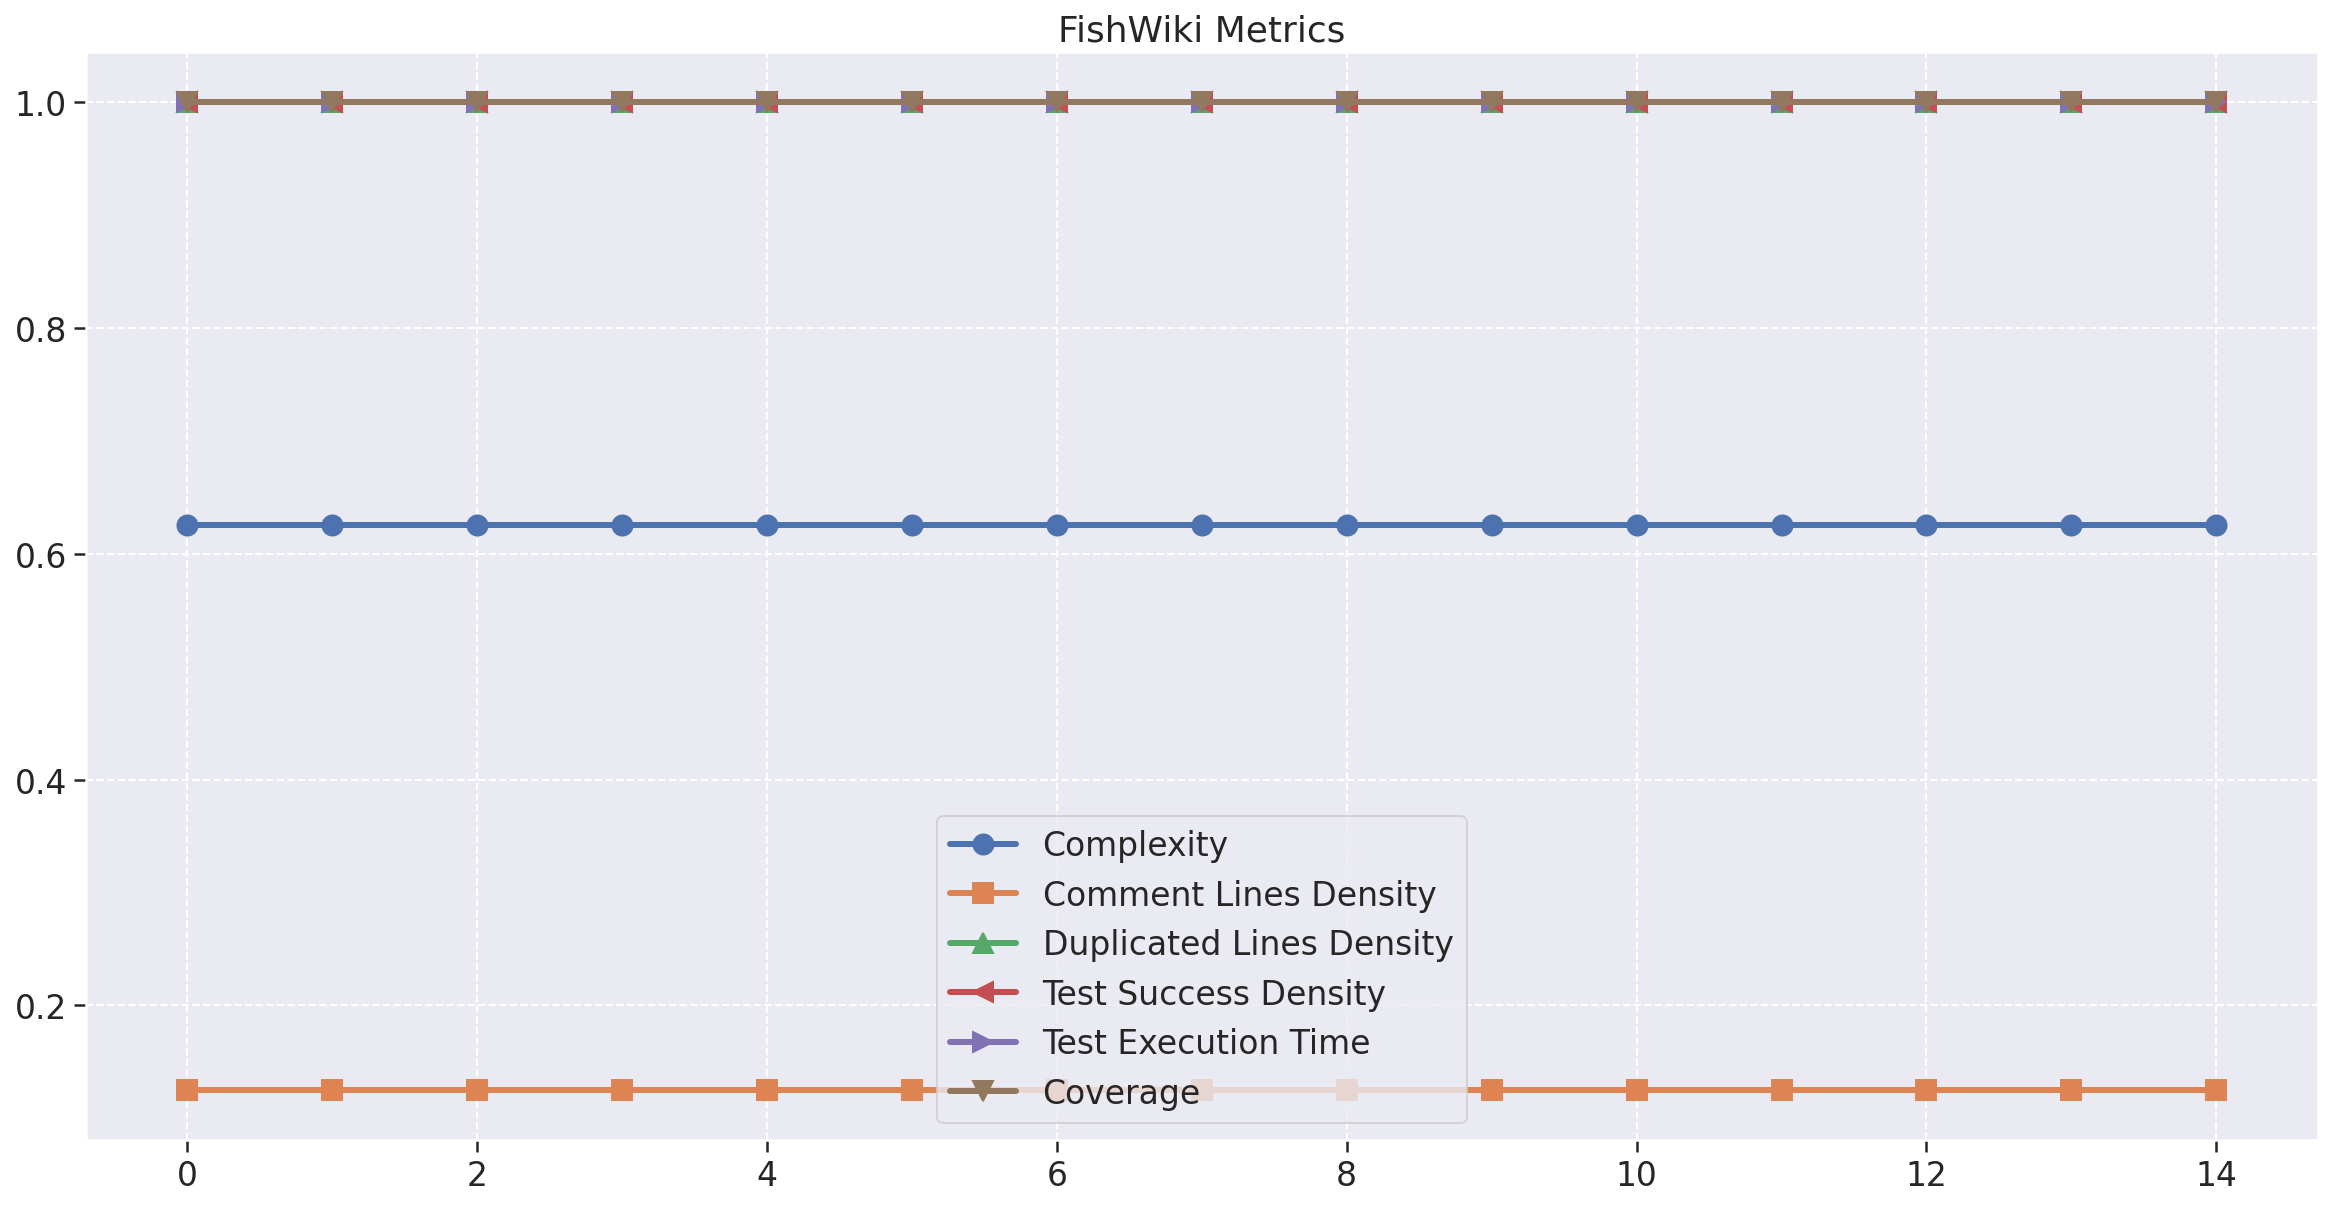

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishWiki Metrics')
plt.plot(repo3_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo3_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo3_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo3_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo3_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo3_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

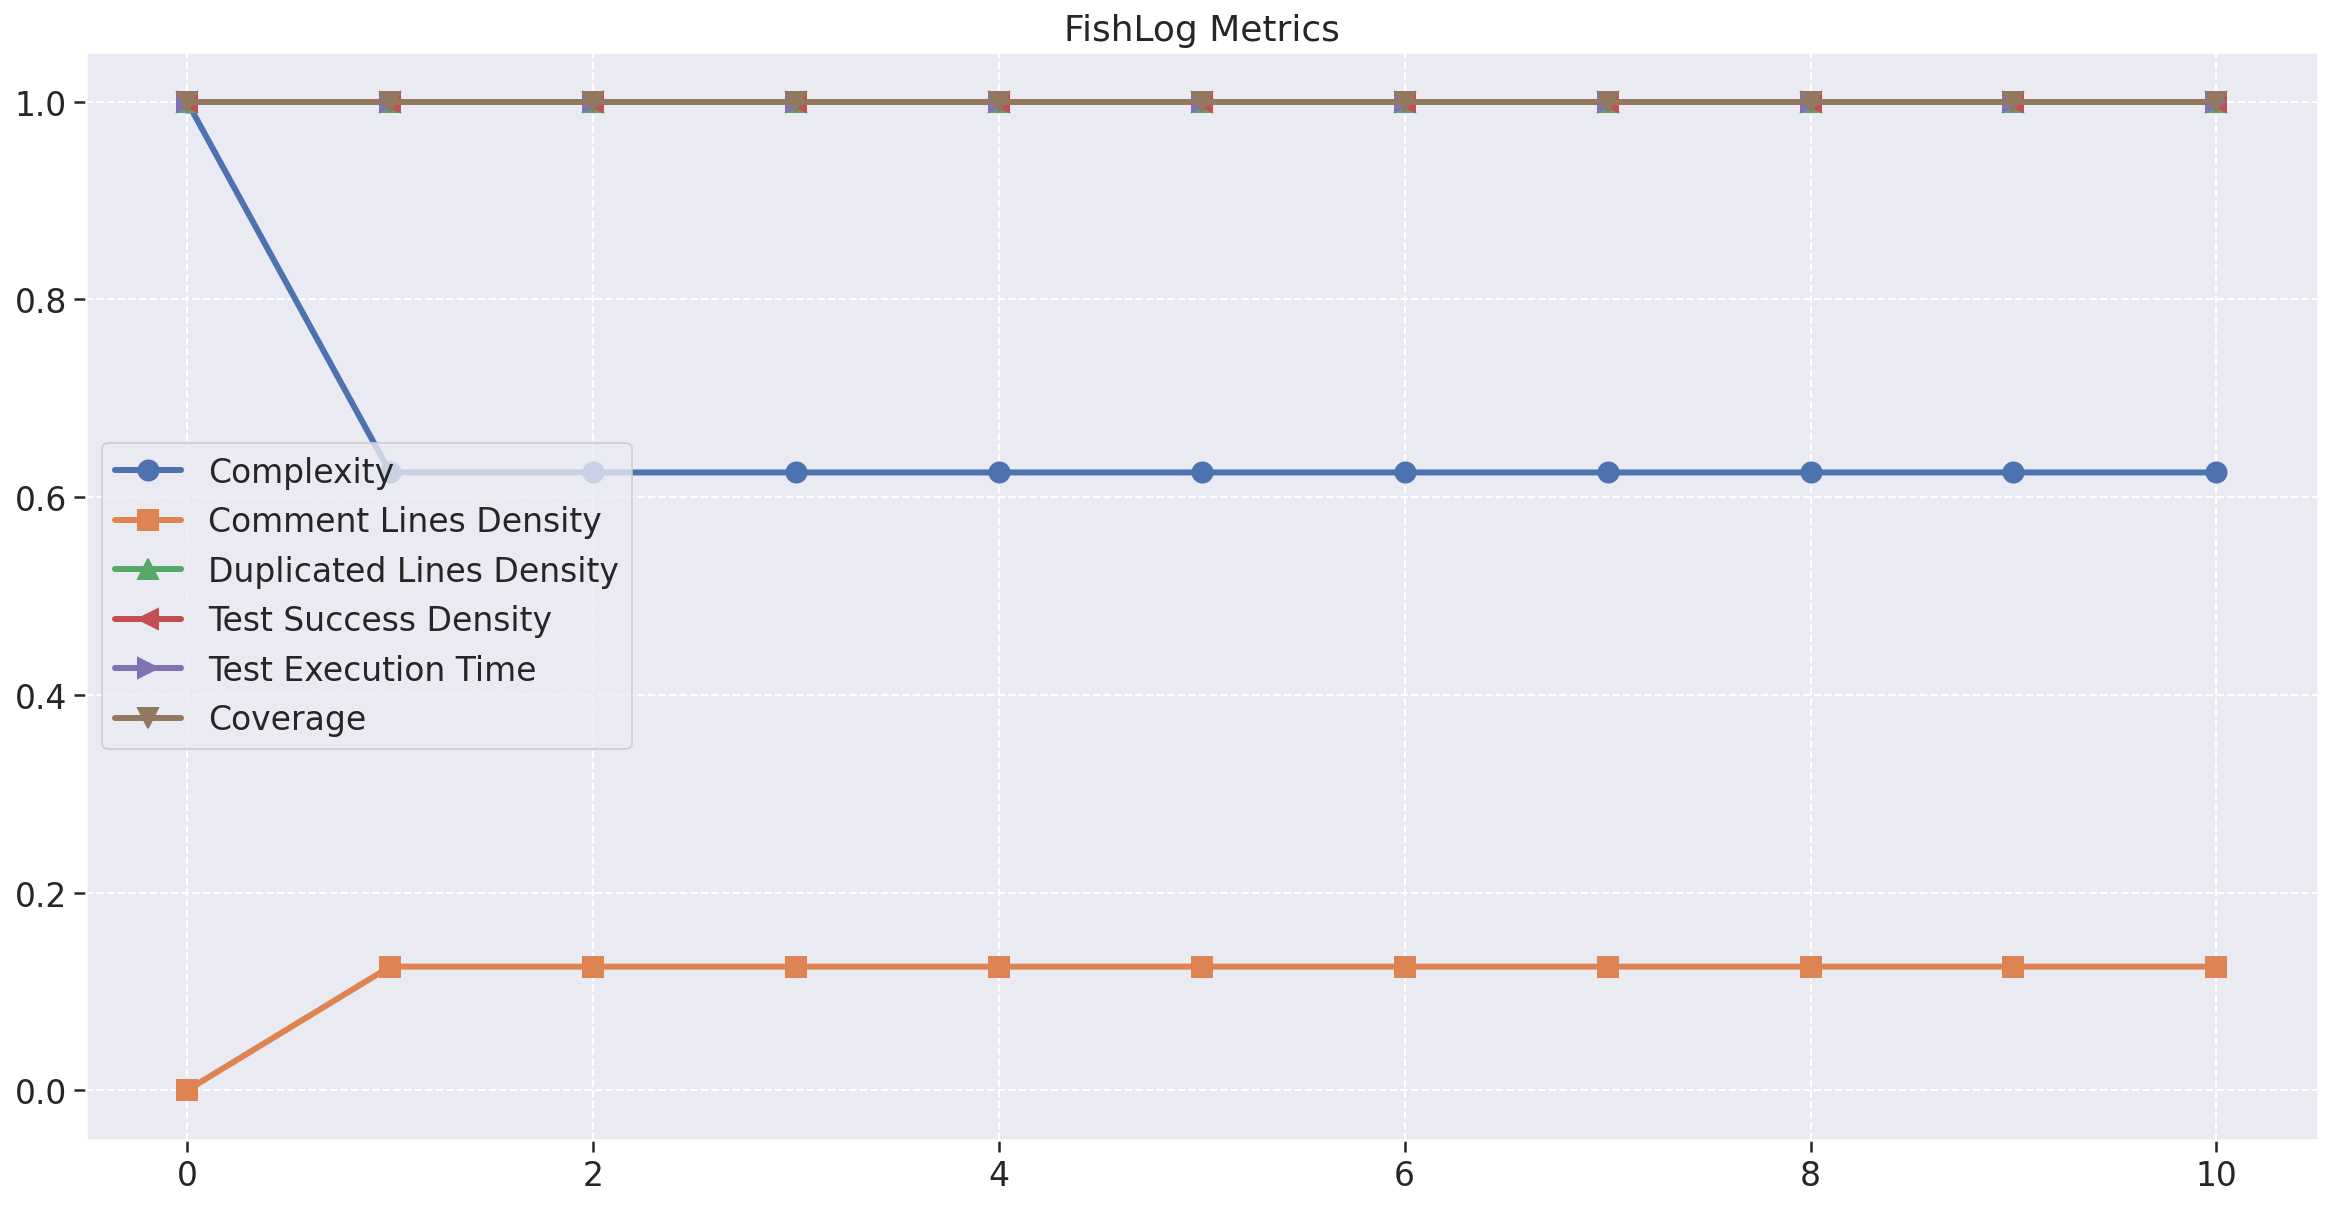

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishLog Metrics')
plt.plot(repo4_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo4_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo4_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo4_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo4_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo4_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [26]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

repo1_metrics['code_quality'] = ((repo1_metrics['m1']*pm1) + (repo1_metrics['m2']*pm2) + (repo1_metrics['m3']*pm3)) * psc1
repo2_metrics['code_quality'] = ((repo2_metrics['m1']*pm1) + (repo2_metrics['m2']*pm2) + (repo2_metrics['m3']*pm3)) * psc1
repo3_metrics['code_quality'] = ((repo3_metrics['m1']*pm1) + (repo3_metrics['m2']*pm2) + (repo3_metrics['m3']*pm3)) * psc1
repo4_metrics['code_quality'] = ((repo4_metrics['m1']*pm1) + (repo4_metrics['m2']*pm2) + (repo4_metrics['m3']*pm3)) * psc1

repo1_metrics['testing_status'] = ((repo1_metrics['m4']*pm4) + (repo1_metrics['m5']*pm5) + (repo1_metrics['m6']*pm6)) * psc2
repo2_metrics['testing_status'] = ((repo2_metrics['m4']*pm4) + (repo2_metrics['m5']*pm5) + (repo2_metrics['m6']*pm6)) * psc2
repo3_metrics['testing_status'] = ((repo3_metrics['m4']*pm4) + (repo3_metrics['m5']*pm5) + (repo3_metrics['m6']*pm6)) * psc2
repo4_metrics['testing_status'] = ((repo4_metrics['m4']*pm4) + (repo4_metrics['m5']*pm5) + (repo4_metrics['m6']*pm6)) * psc2


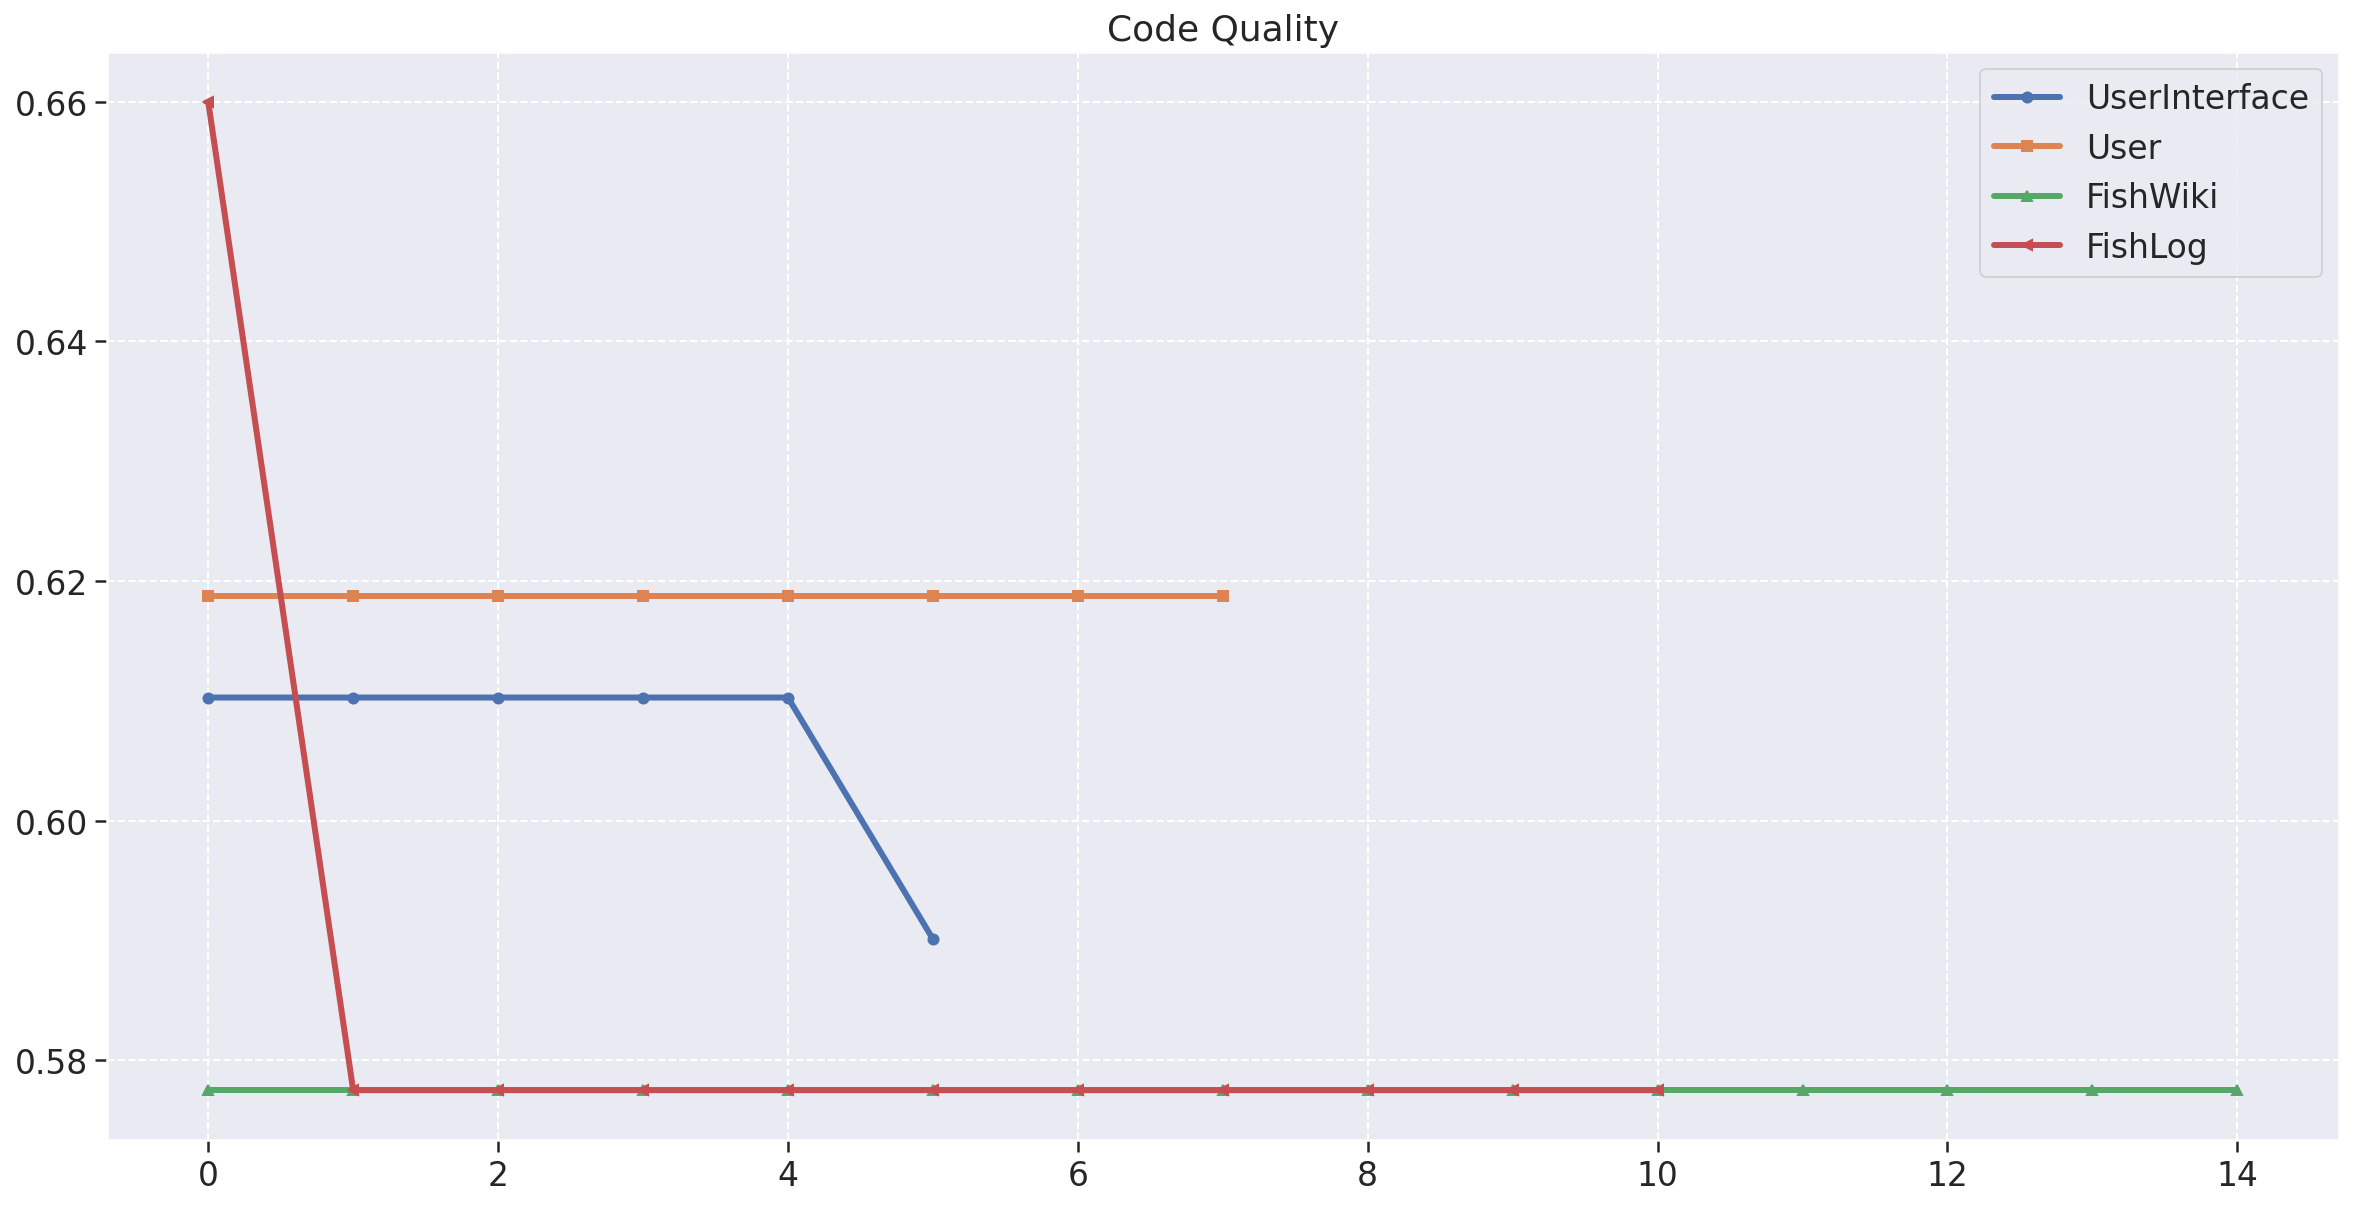

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.title('Code Quality')
plt.plot(repo1_metrics['code_quality'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['code_quality'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['code_quality'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['code_quality'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

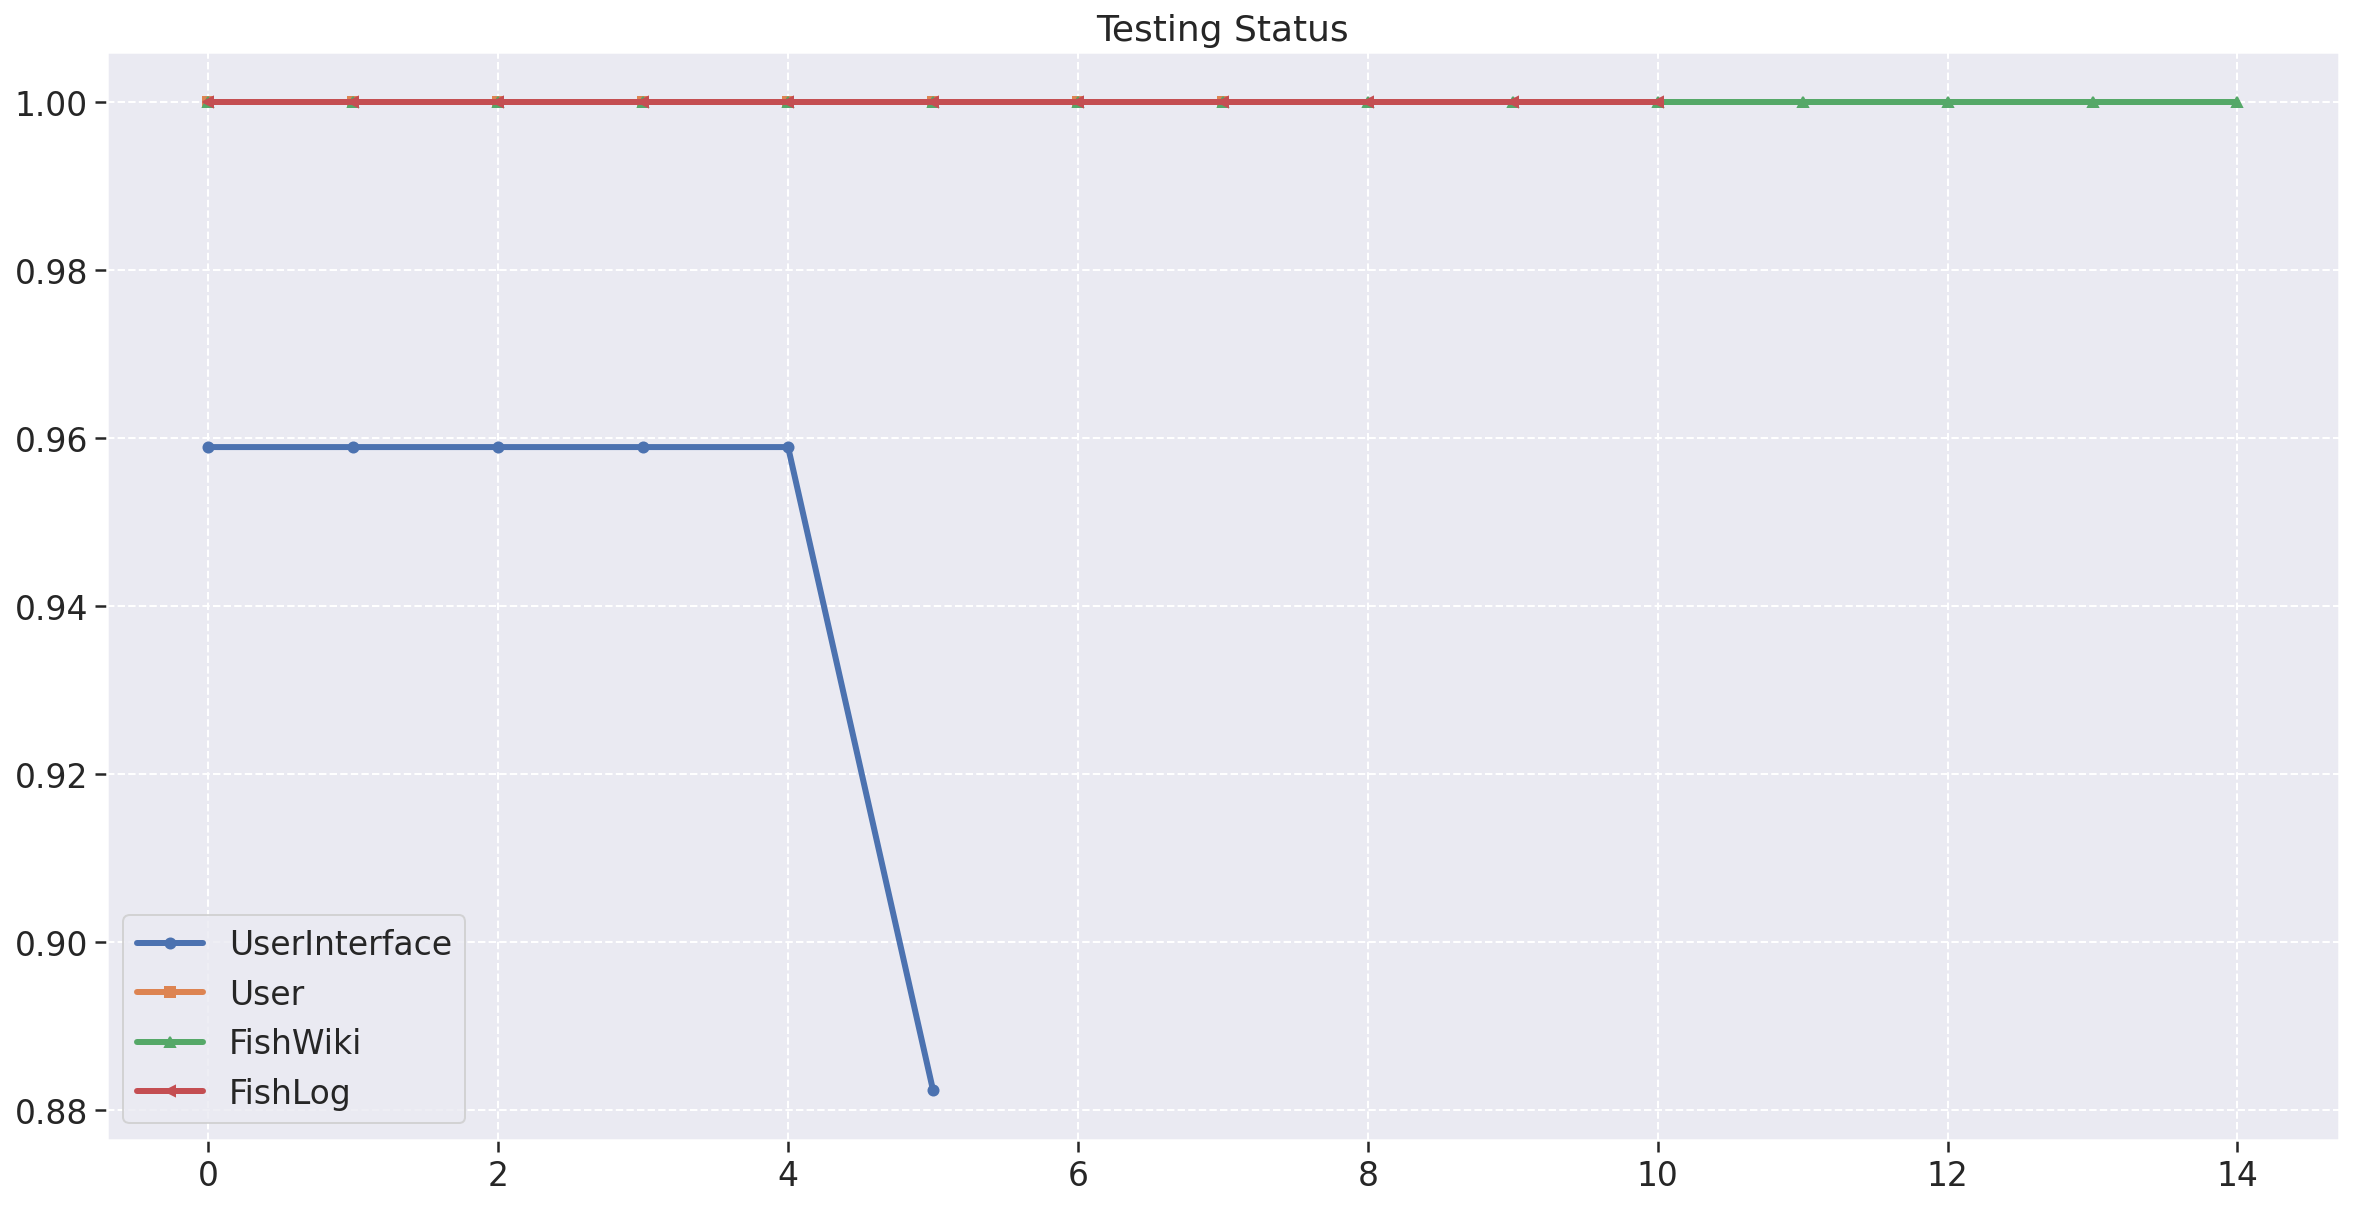

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(repo1_metrics['testing_status'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['testing_status'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['testing_status'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['testing_status'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

In [29]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, repo3_metrics, repo4_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

(0.2, 0.6)

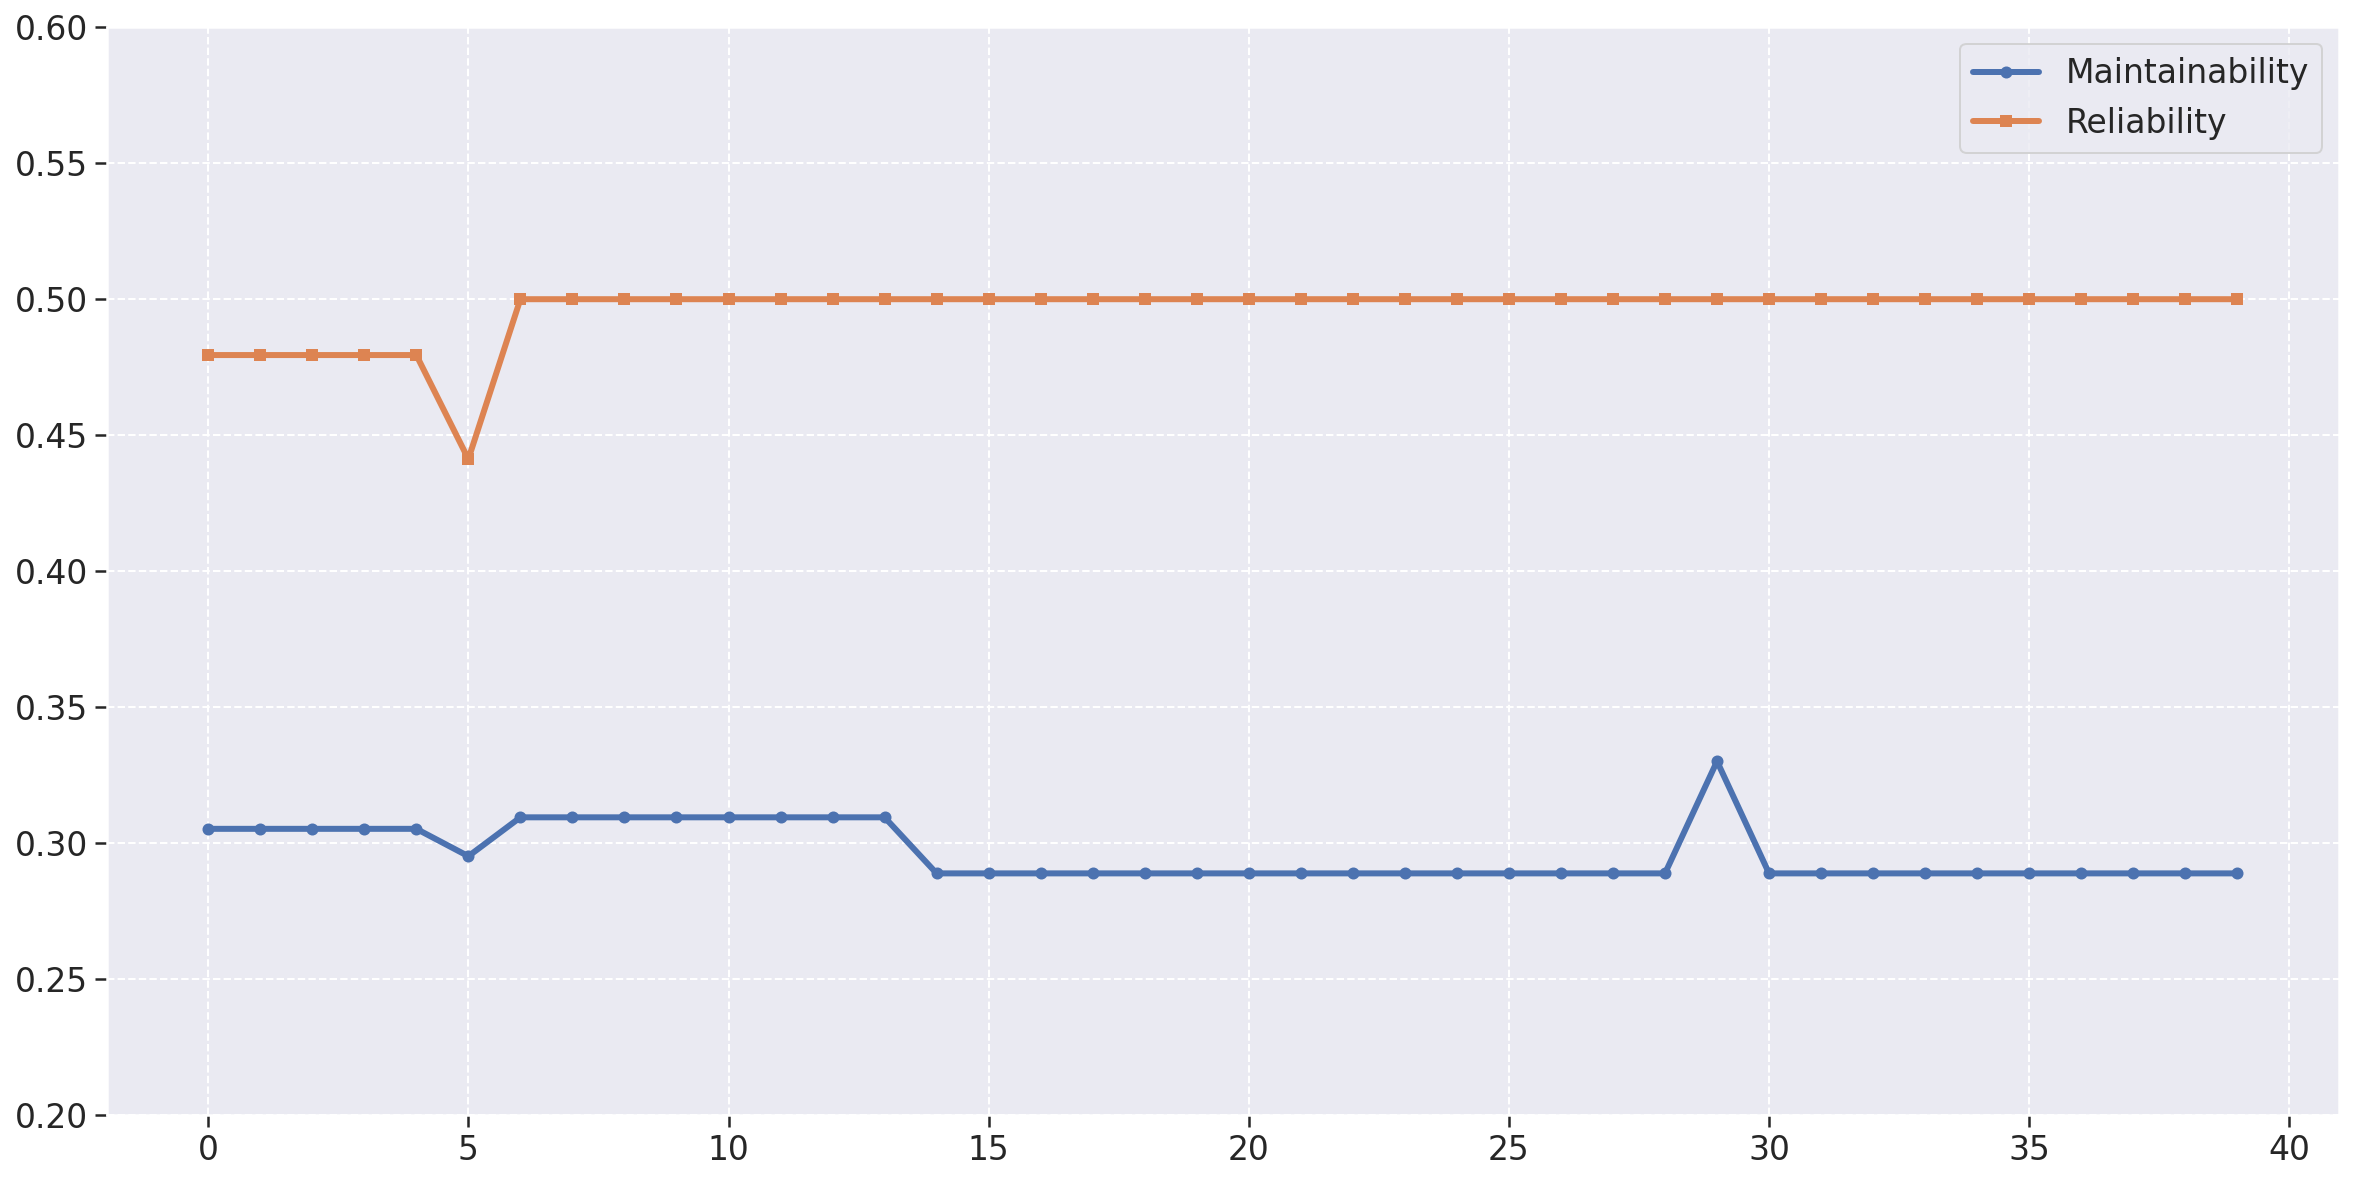

In [30]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='s', label='Reliability', markersize=5)
plt.legend()
plt.ylim(.2,.6)

(0.65, 0.9)

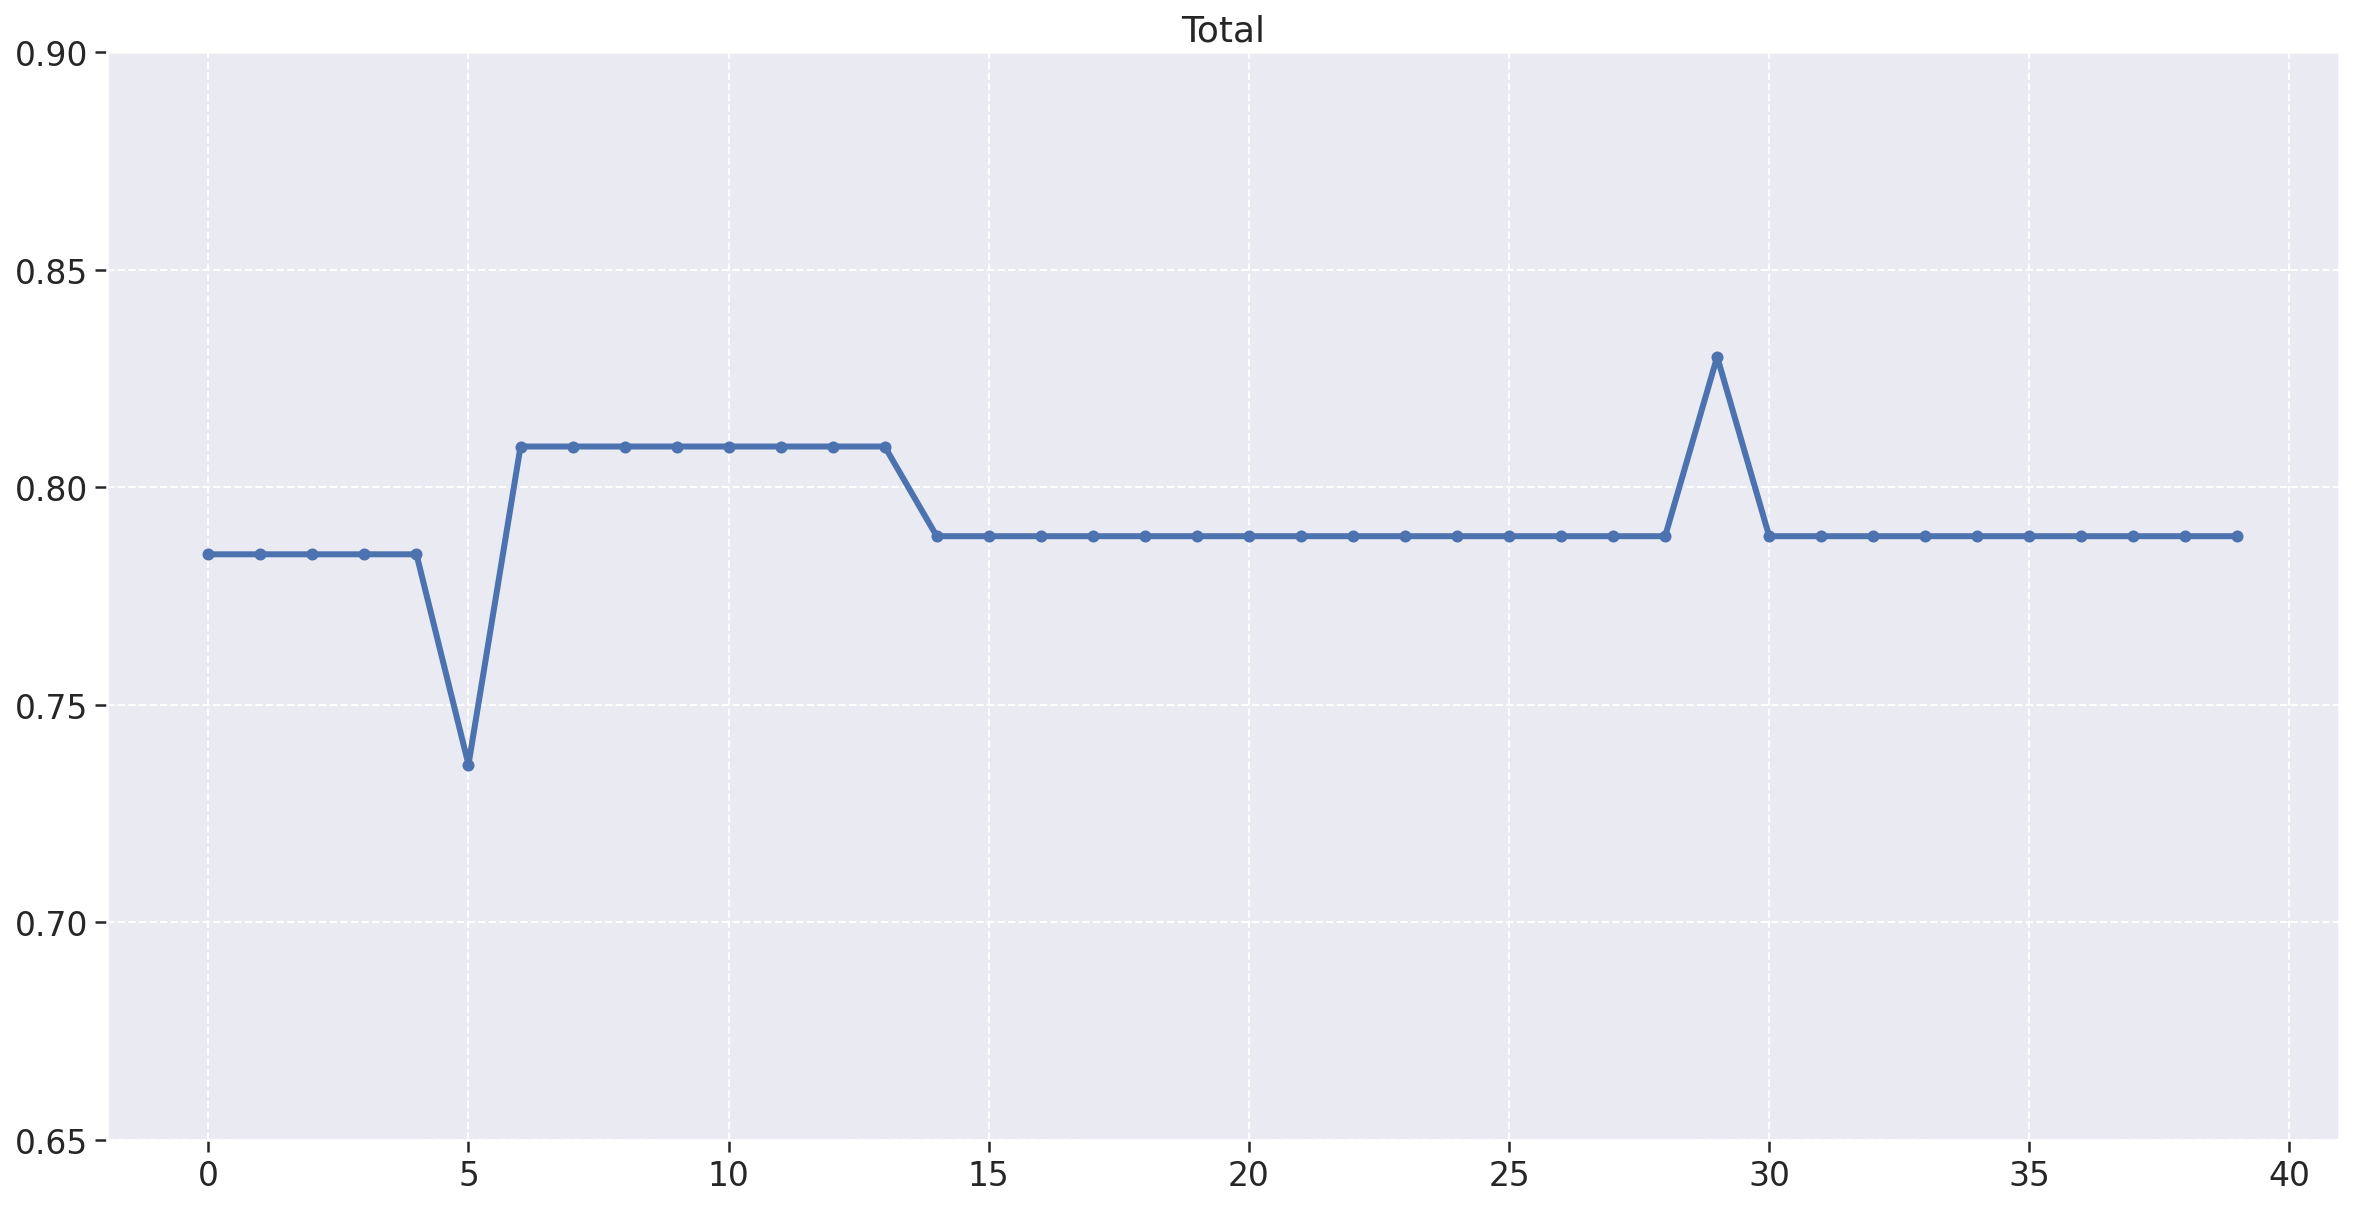

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)
plt.ylim(.65,.9)

In [32]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

# metrics_df.to_excel('data/fga-eps-mds-Pro-Especies-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_df.to_csv('data/fga-eps-mds-Pro-Especies-DATASET-{}.csv'.format(currentTime), index = False)

In [33]:
descriptive_statistics_df = pd.DataFrame()

descriptive_statistics_df['mode_reliability'] = metrics_df['Reliability'].mode()
descriptive_statistics_df['mode_maintainability'] = metrics_df['maintainability'].mode()
descriptive_statistics_df['median_reliability'] = metrics_df['Reliability'].median()
descriptive_statistics_df['median_maintainability'] = metrics_df['maintainability'].median()
descriptive_statistics_df['mean_reliability'] = metrics_df['Reliability'].mean()
descriptive_statistics_df['mean_maintainability'] = metrics_df['maintainability'].mean()
descriptive_statistics_df['max_reliability'] = metrics_df['Reliability'].max()
descriptive_statistics_df['max_maintainability'] = metrics_df['maintainability'].max()
descriptive_statistics_df['min_reliability'] = metrics_df['Reliability'].min()
descriptive_statistics_df['min_maintainability'] = metrics_df['maintainability'].min()
descriptive_statistics_df['std_dev_reliability'] = metrics_df['Reliability'].std()
descriptive_statistics_df['std_dev_maintainability'] = metrics_df['maintainability'].std()
descriptive_statistics_df['variance_reliability'] = metrics_df['Reliability'].var()
descriptive_statistics_df['variance_maintainability'] = metrics_df['maintainability'].var()

descriptive_statistics_df

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,0.5,0.28875,0.5,0.28875,0.495961,0.296112,0.5,0.33,0.441176,0.28875,0.01123,0.010523,0.000126,0.000111


In [34]:
descriptive_statistics_archives = pd.DataFrame()

descriptive_statistics_archives['mode_reliability'] = metrics_df['testing_status'].mode()
descriptive_statistics_archives['mode_maintainability'] = metrics_df['code_quality'].mode()
descriptive_statistics_archives['median_reliability'] = metrics_df['testing_status'].median()
descriptive_statistics_archives['median_maintainability'] = metrics_df['code_quality'].median()
descriptive_statistics_archives['mean_reliability'] = metrics_df['testing_status'].mean()
descriptive_statistics_archives['mean_maintainability'] = metrics_df['code_quality'].mean()
descriptive_statistics_archives['max_reliability'] = metrics_df['testing_status'].max()
descriptive_statistics_archives['max_maintainability'] = metrics_df['code_quality'].max()
descriptive_statistics_archives['min_reliability'] = metrics_df['testing_status'].min()
descriptive_statistics_archives['min_maintainability'] = metrics_df['code_quality'].min()
descriptive_statistics_archives['std_dev_reliability'] = metrics_df['testing_status'].std()
descriptive_statistics_archives['std_dev_maintainability'] = metrics_df['code_quality'].std()
descriptive_statistics_archives['variance_reliability'] = metrics_df['testing_status'].var()
descriptive_statistics_archives['variance_maintainability'] = metrics_df['code_quality'].var()

descriptive_statistics_archives

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,1.0,0.5775,1.0,0.5775,0.991922,0.592225,1.0,0.66,0.882353,0.5775,0.022461,0.021047,0.000504,0.000443


In [35]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.863014,0.027397,0.958904,0.958904,0.958904,0.958904,UserInterface,10-16-2021-12-52,3796,0.610274,0.958904,0.305137,0.479452,0.784589
1,0.863014,0.027397,0.958904,0.958904,0.958904,0.958904,UserInterface,10-16-2021-12-57,3796,0.610274,0.958904,0.305137,0.479452,0.784589
2,0.863014,0.027397,0.958904,0.958904,0.958904,0.958904,UserInterface,10-18-2021-16-07,3796,0.610274,0.958904,0.305137,0.479452,0.784589
3,0.863014,0.027397,0.958904,0.958904,0.958904,0.958904,UserInterface,10-19-2021-16-46,3796,0.610274,0.958904,0.305137,0.479452,0.784589
4,0.863014,0.027397,0.958904,0.958904,0.958904,0.958904,UserInterface,10-21-2021-17-56,3796,0.610274,0.958904,0.305137,0.479452,0.784589
5,0.870588,0.035294,0.882353,0.882353,0.882353,0.882353,UserInterface,11-08-2021-23-08,5458,0.590118,0.882353,0.295059,0.441176,0.736235
6,0.750000,0.125000,1.000000,1.000000,1.000000,1.000000,User,09-13-2021-22-00,211,0.618750,1.000000,0.309375,0.500000,0.809375
7,0.750000,0.125000,1.000000,1.000000,1.000000,1.000000,User,09-15-2021-22-42,211,0.618750,1.000000,0.309375,0.500000,0.809375
8,0.750000,0.125000,1.000000,1.000000,1.000000,1.000000,User,10-16-2021-13-06,211,0.618750,1.000000,0.309375,0.500000,0.809375
9,0.750000,0.125000,1.000000,1.000000,1.000000,1.000000,User,10-19-2021-14-23,211,0.618750,1.000000,0.309375,0.500000,0.809375


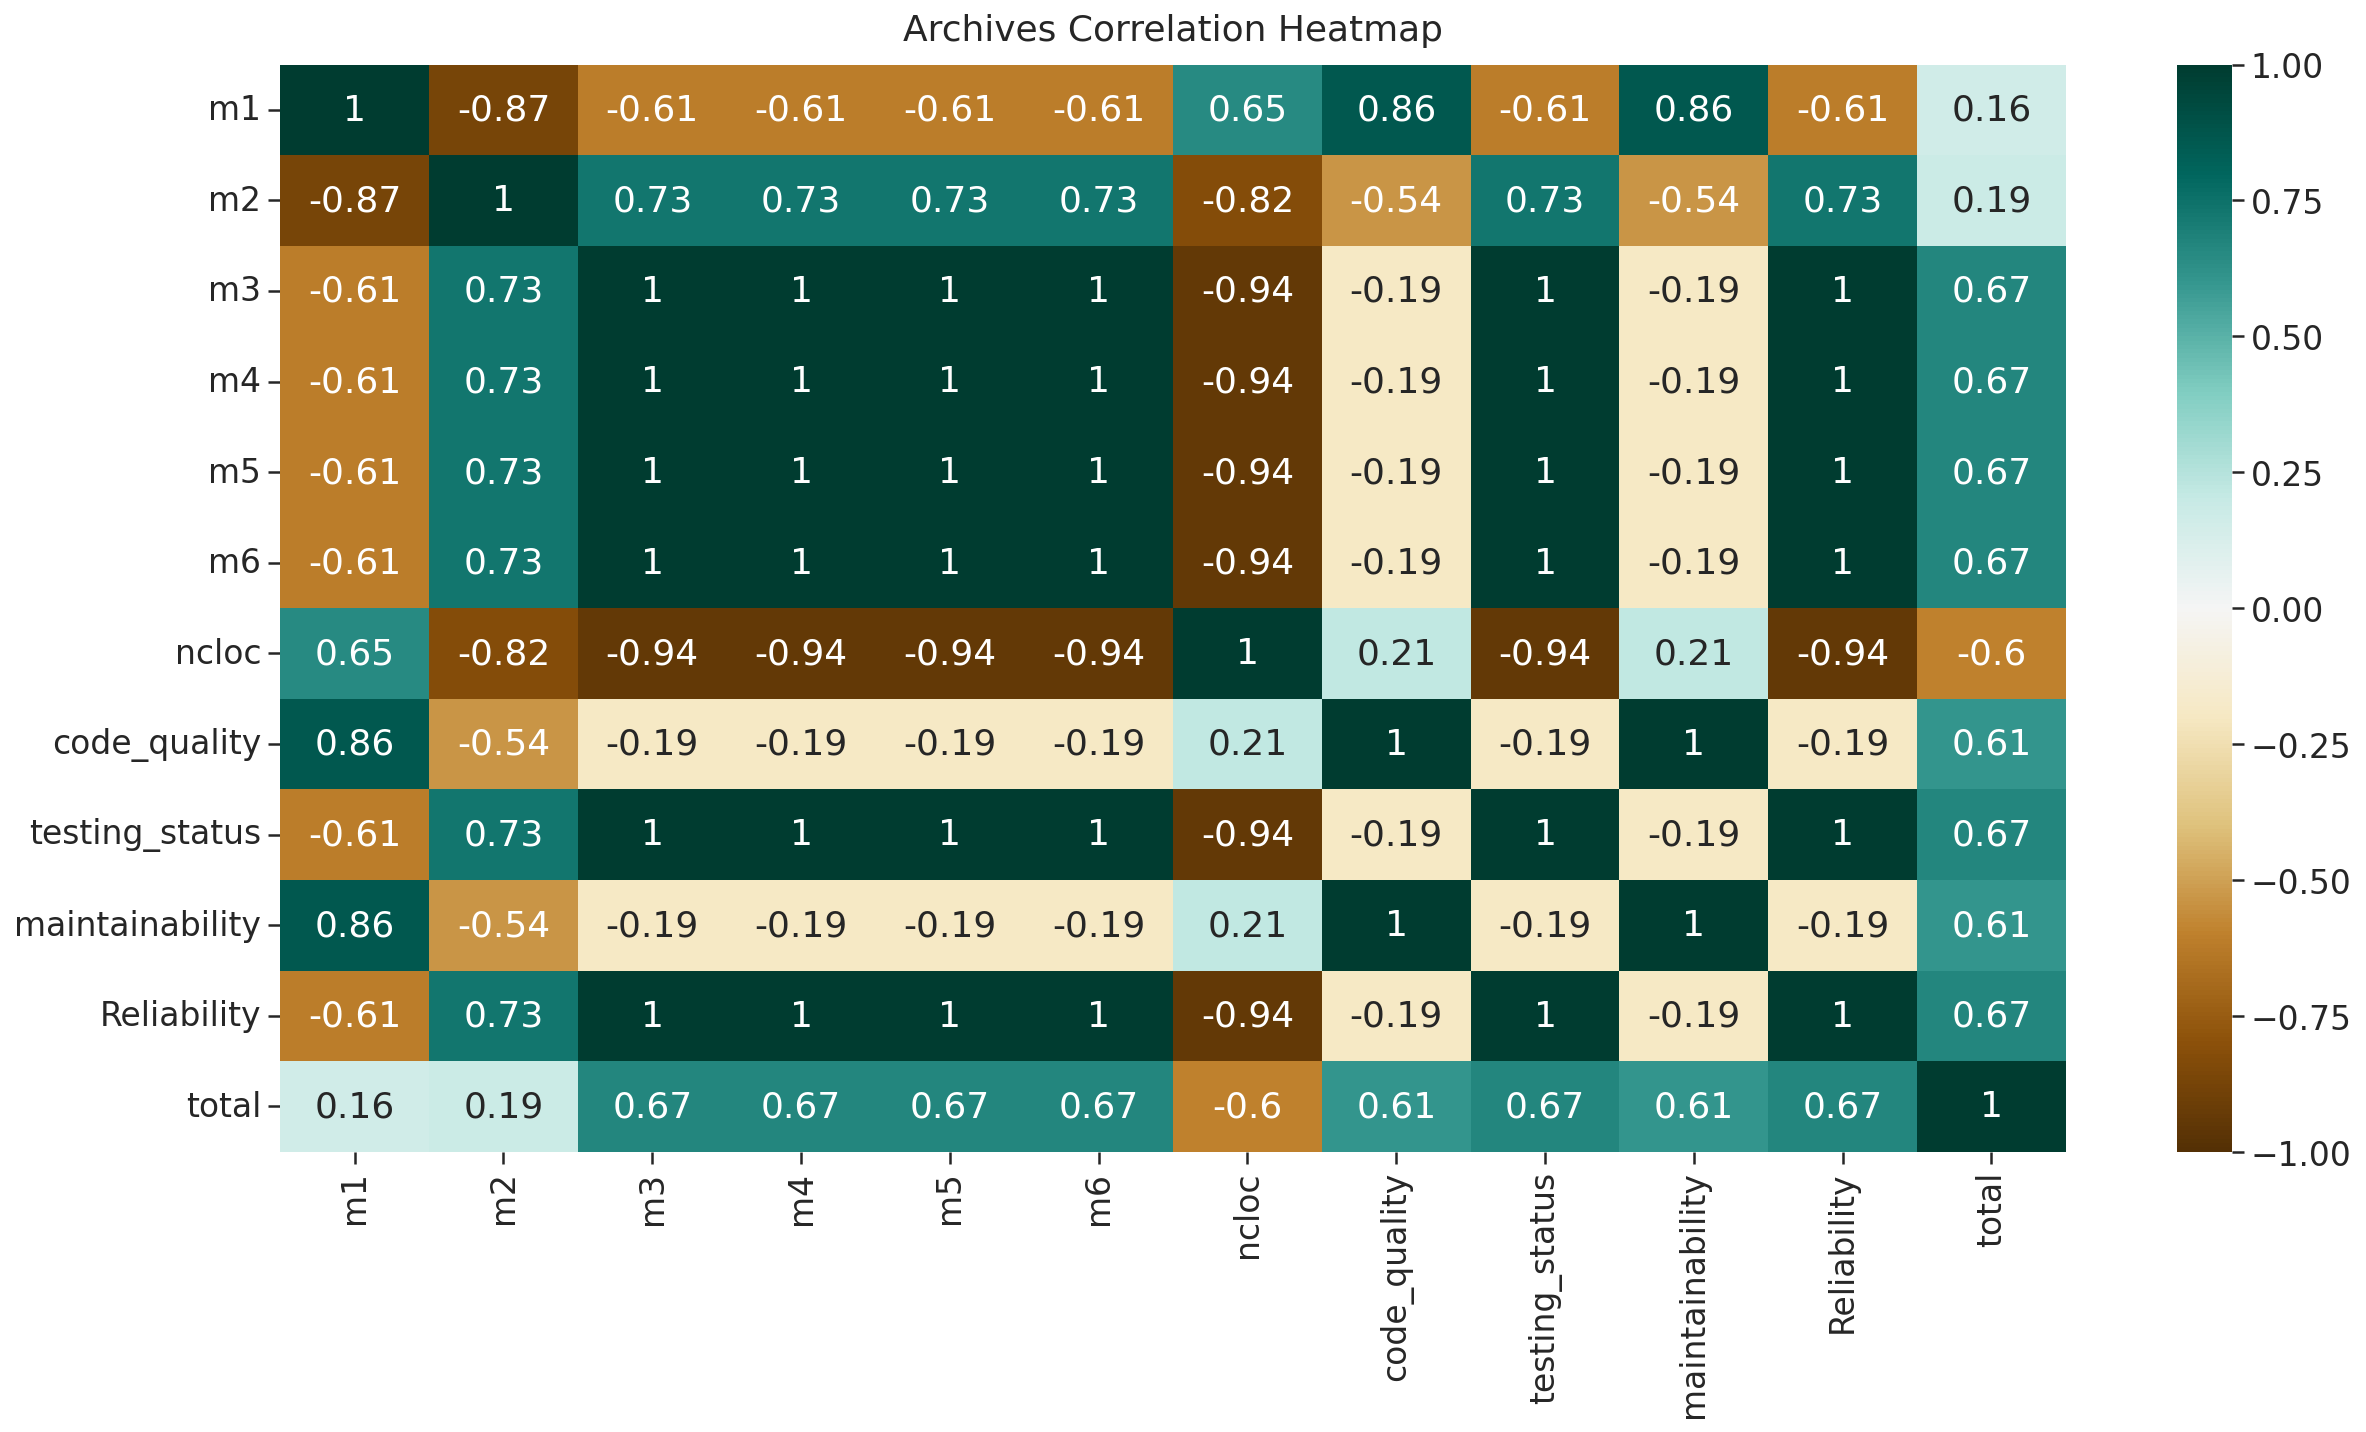

In [36]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(metrics_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Archives Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

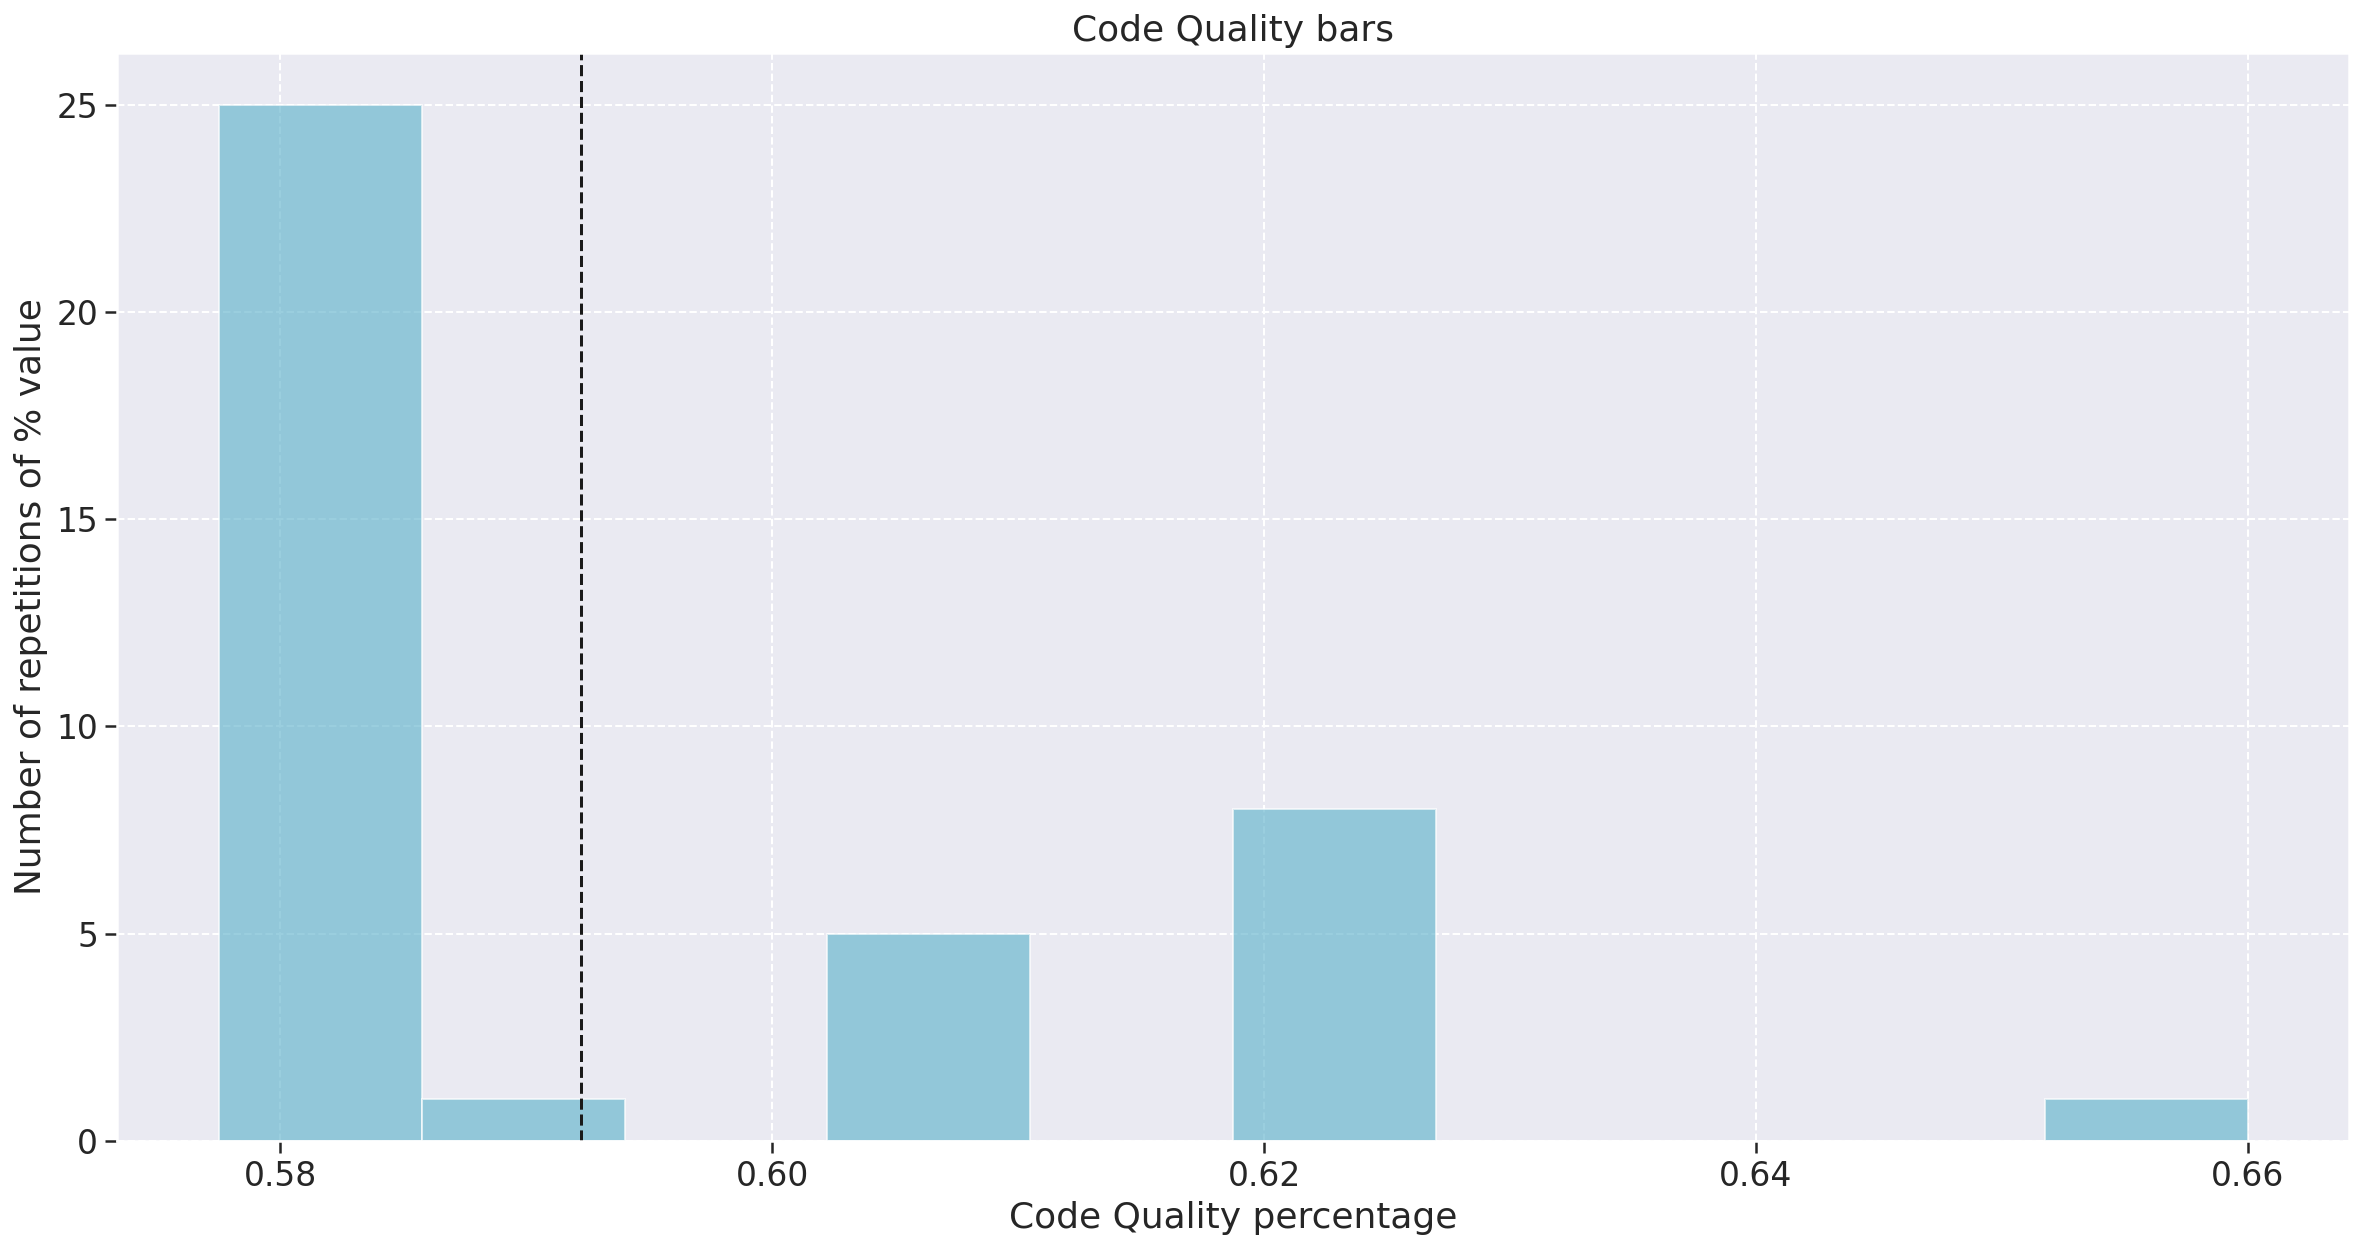

In [37]:
fig = plt.figure(figsize=(20, 10))

plt.title("Code Quality bars")
plt.ylabel("Number of repetitions of % value")
plt.xlabel("Code Quality percentage")
plt.hist(metrics_df['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(metrics_df['code_quality'].mean(), color='k', linestyle='dashed')

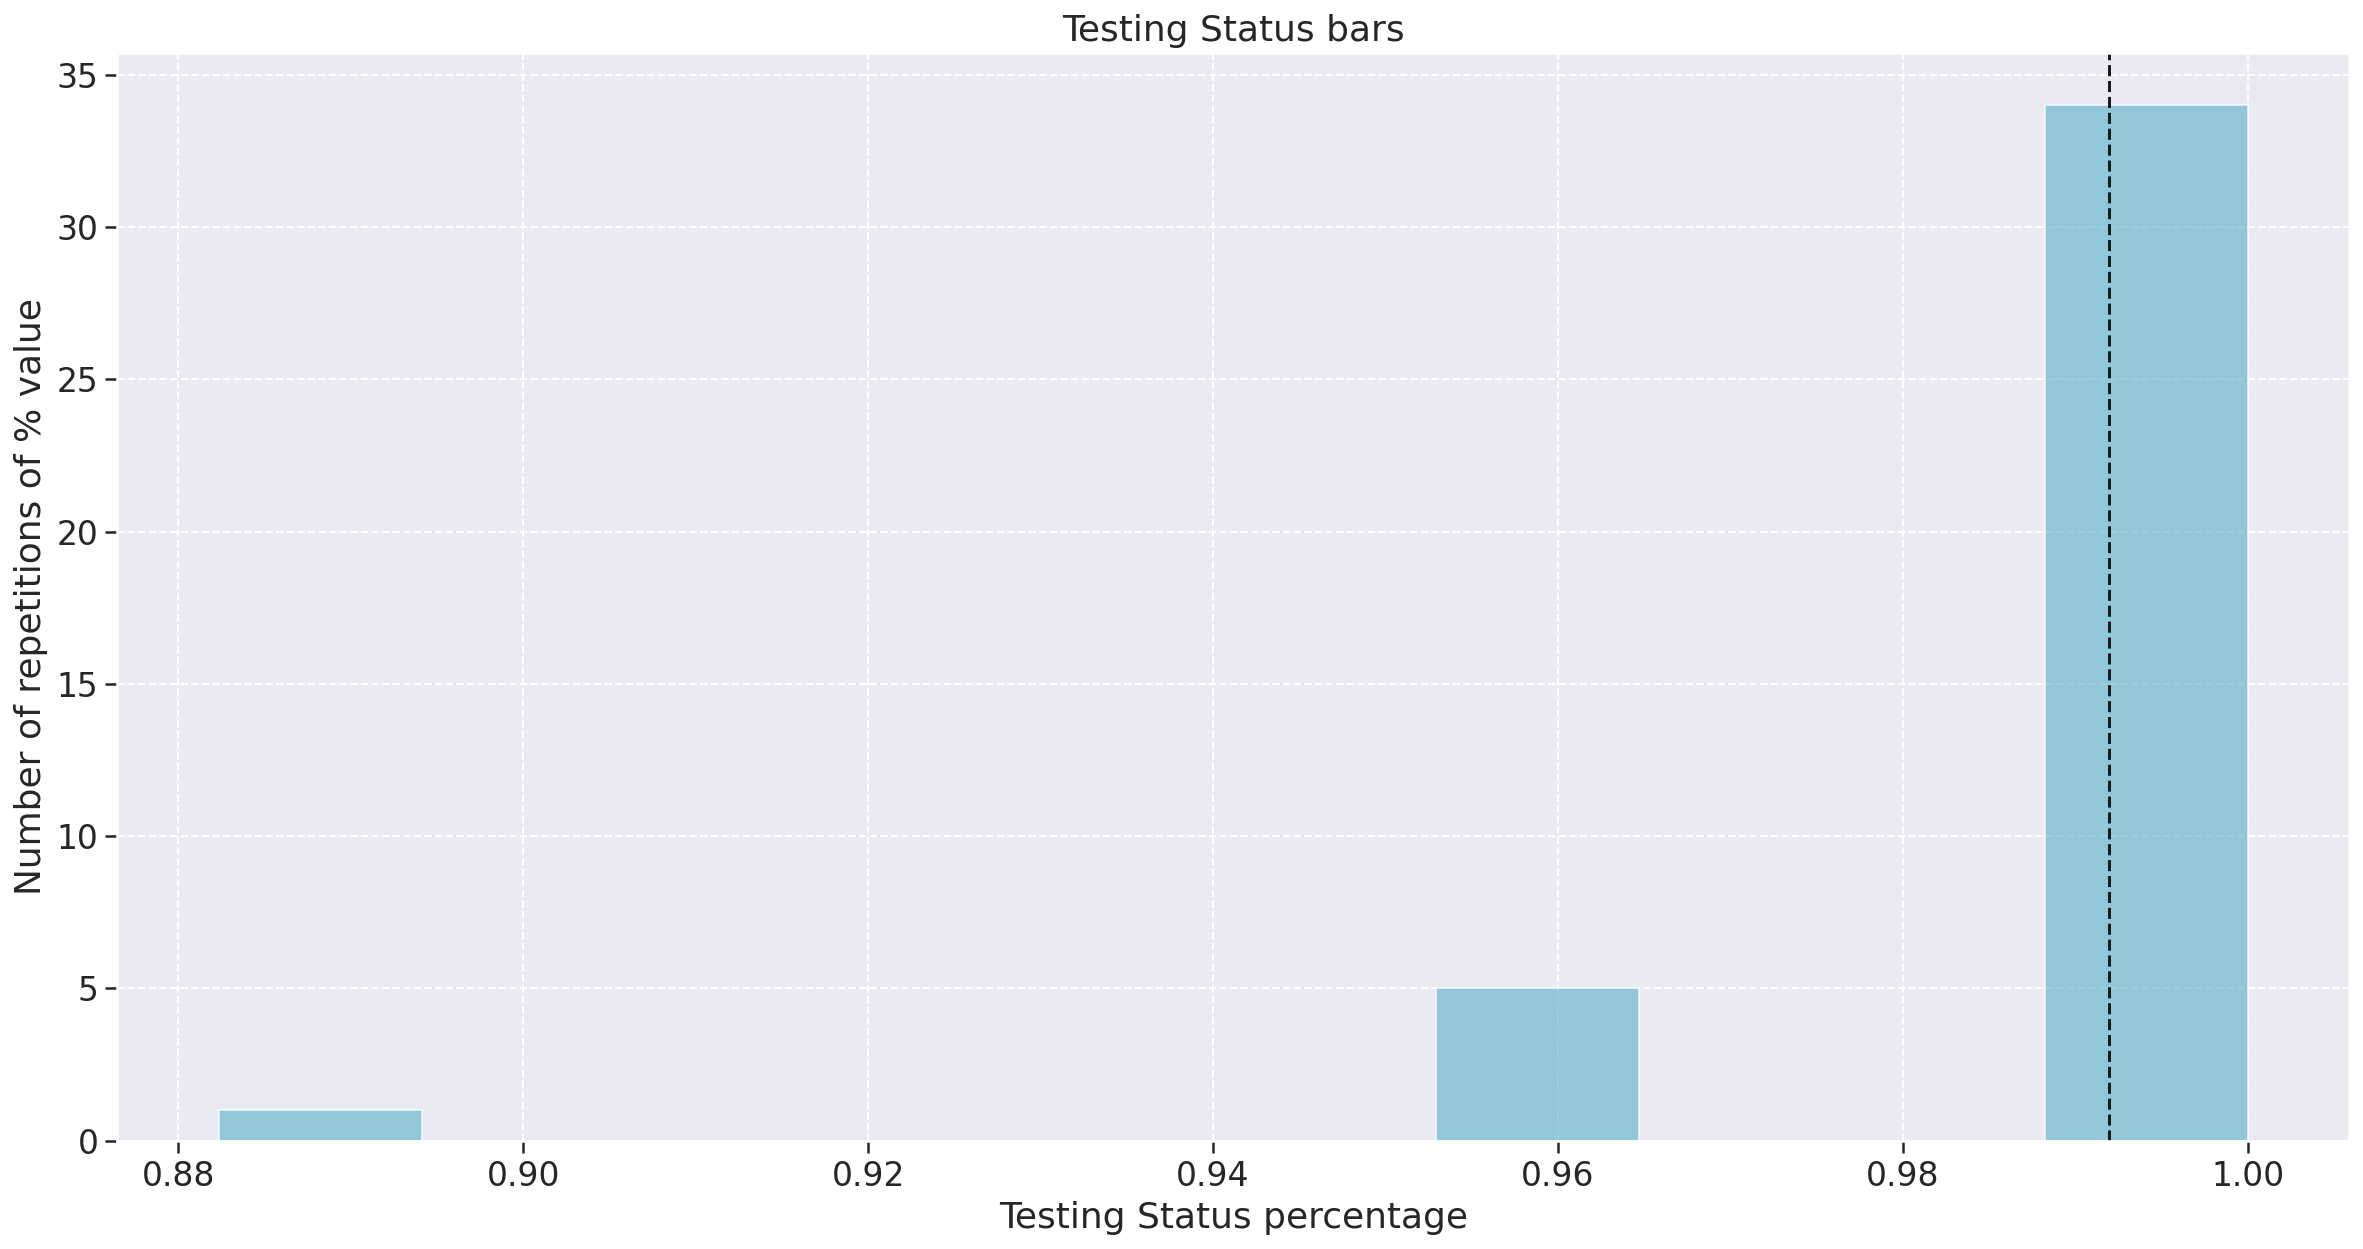

In [38]:

fig = plt.figure(figsize=(20, 10))

plt.title("Testing Status bars")
plt.ylabel("Number of repetitions of % value")
plt.xlabel("Testing Status percentage")
plt.hist(metrics_df['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(metrics_df['testing_status'].mean(), color='k', linestyle='dashed')

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff0f6592a30>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff0f65a20d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff0f65925e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff0f65a27f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff0f65a2b80>],
 'means': []}

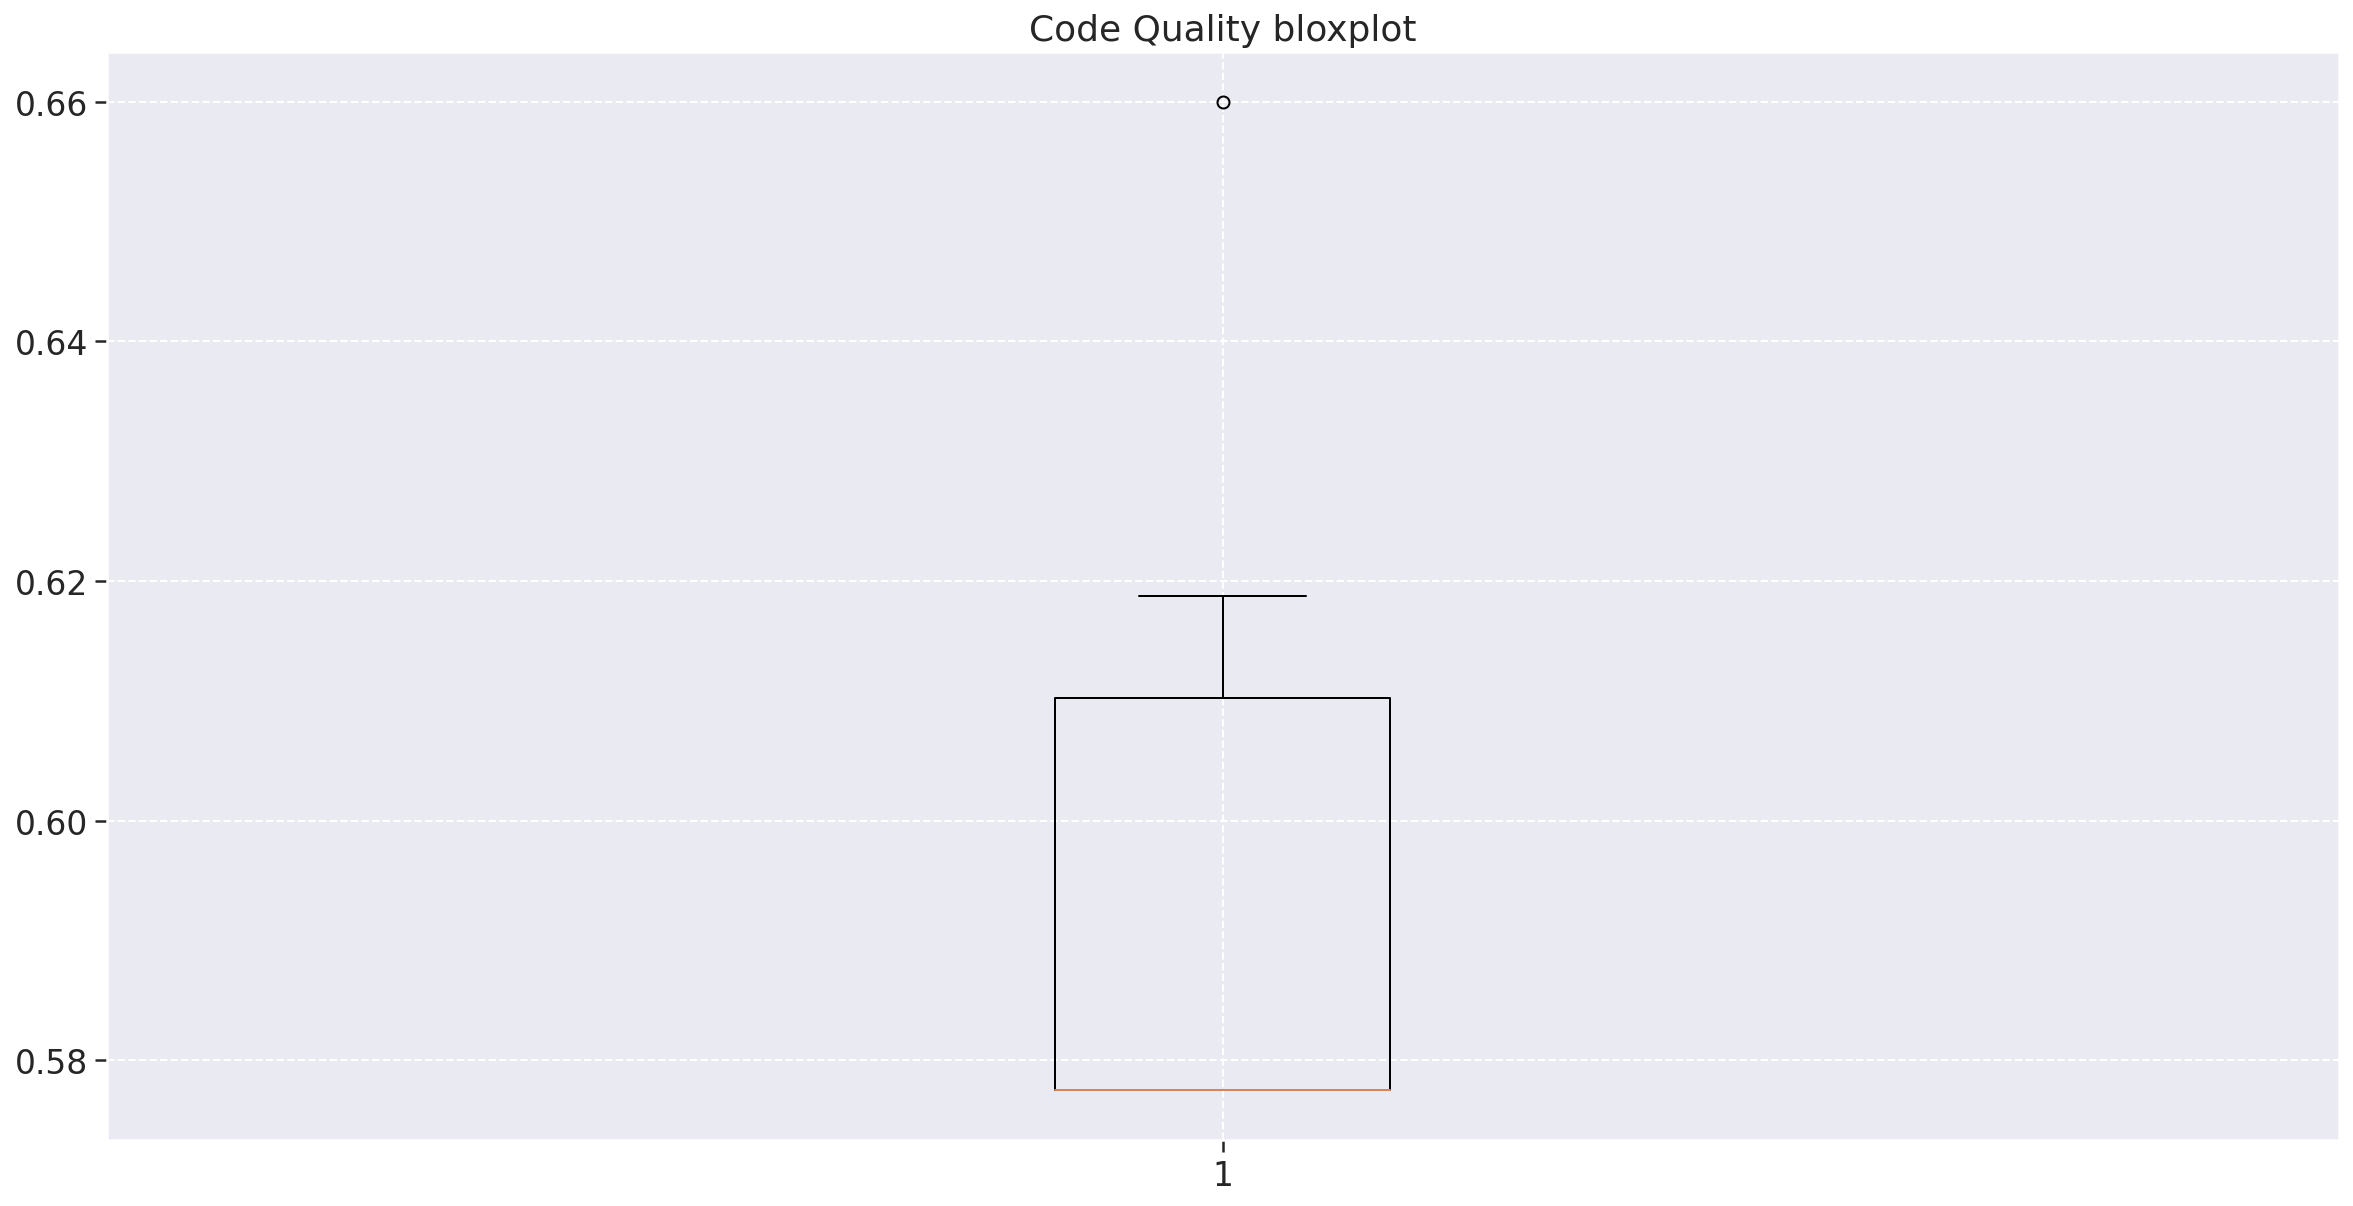

In [39]:
fig = plt.figure(figsize=(20, 10))

plt.title("Code Quality bloxplot")
plt.boxplot(metrics_df['code_quality'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff0f6975ca0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff0f6950430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff0f69755b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff0f6950b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff0f69695b0>],
 'means': []}

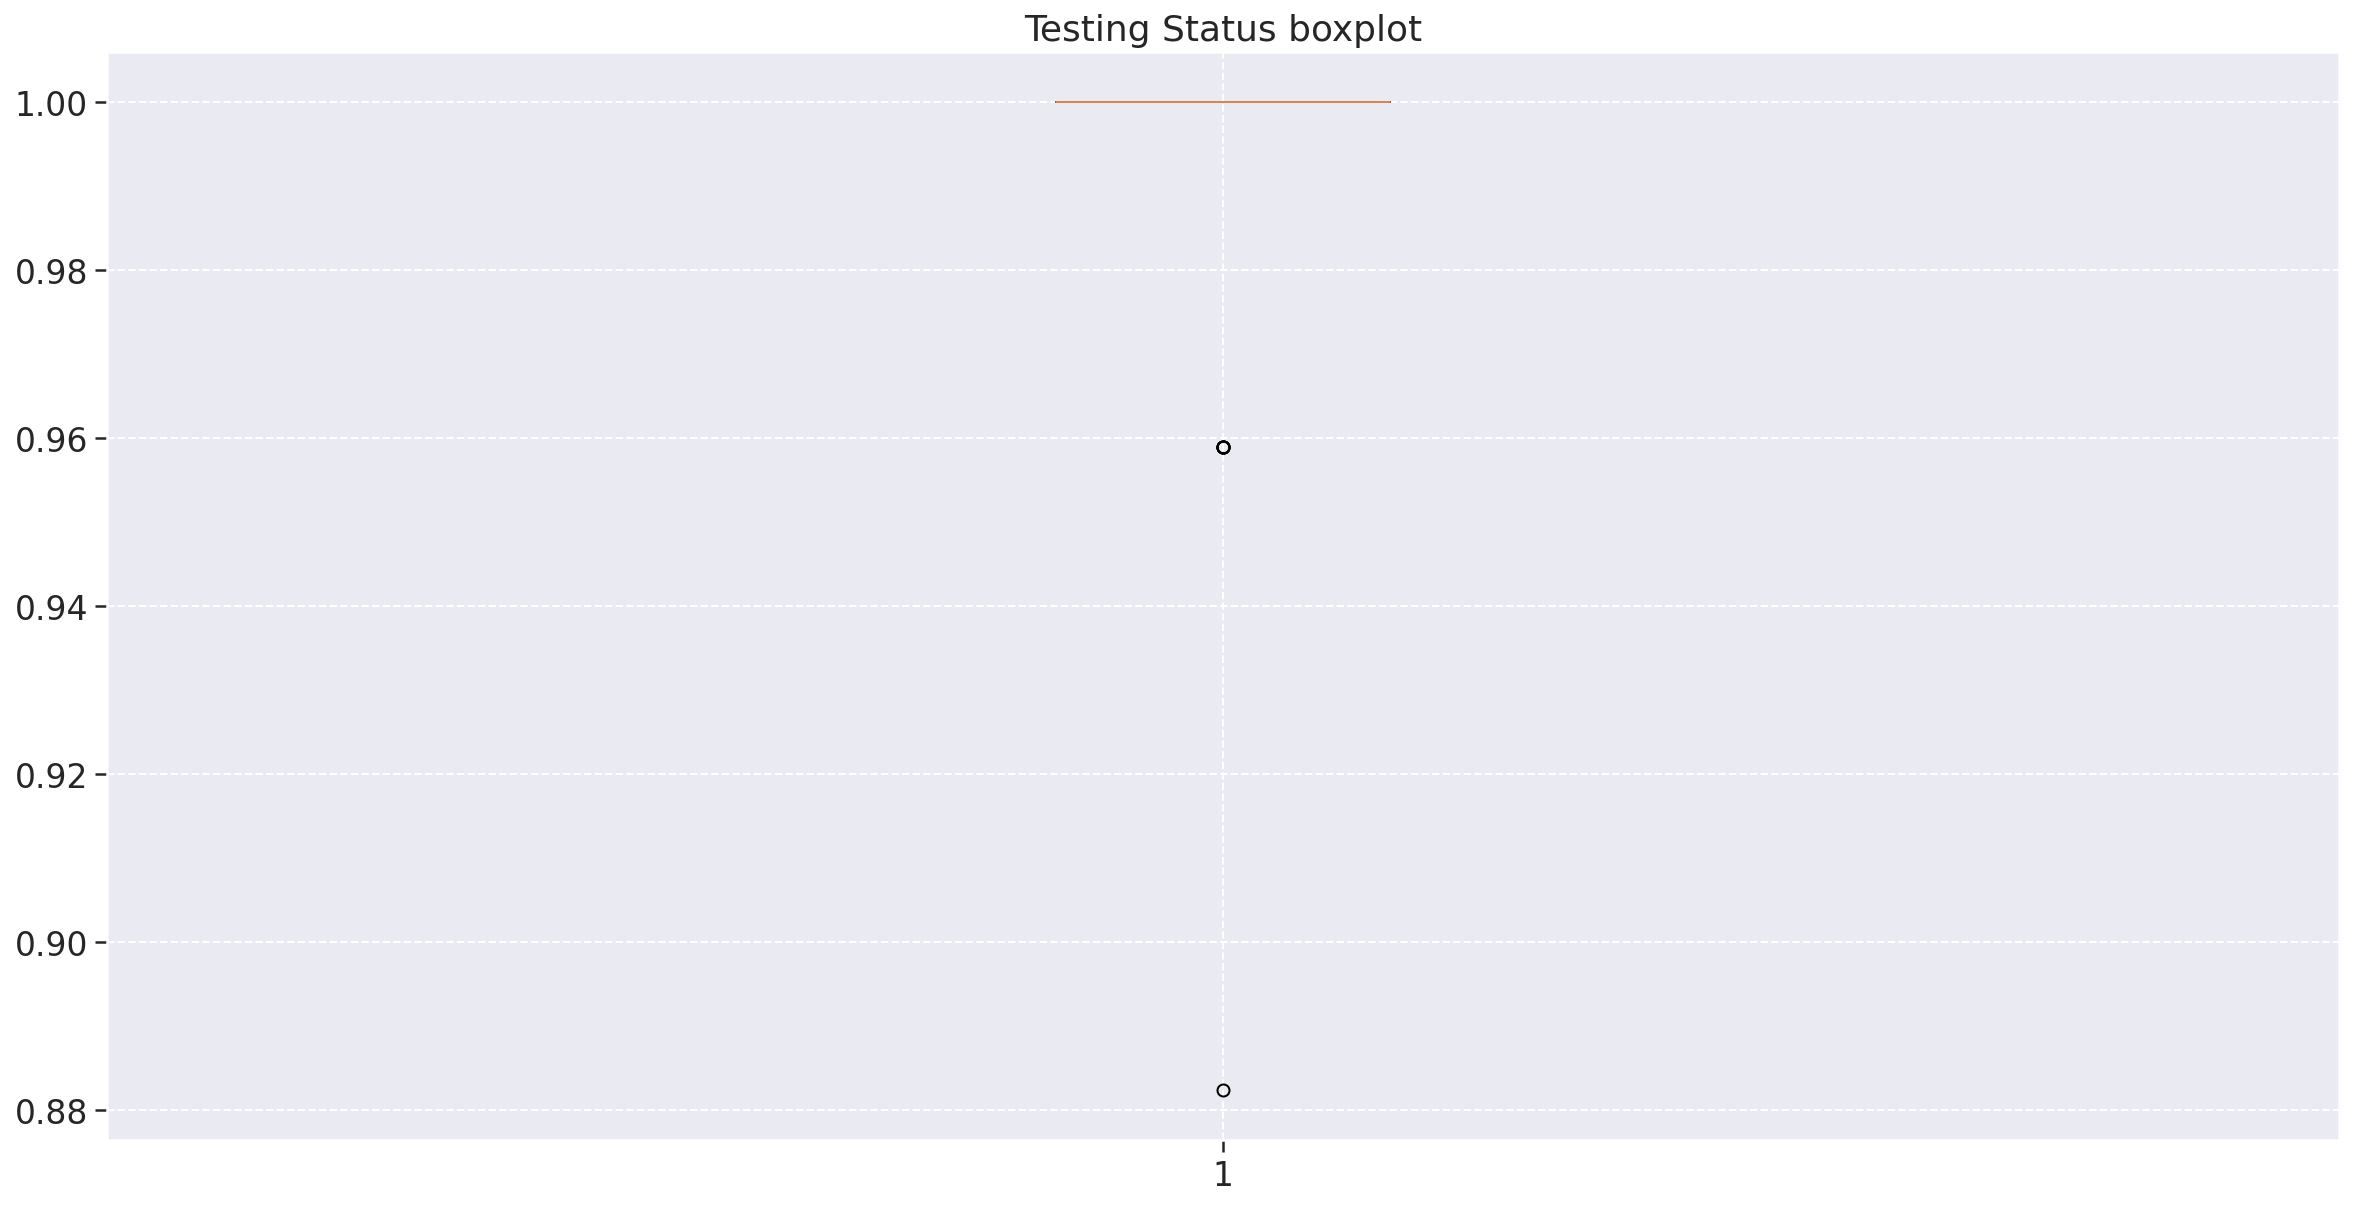

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.title("Testing Status boxplot")
plt.boxplot(metrics_df['testing_status'])